In [1]:
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import math
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import os
import random
import tqdm

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
import matplotlib.pyplot as plt

class Island:
    def __init__(self, xcentr=5, ycentr=5, radius=1):
        self.xcentr = xcentr
        self.ycentr = ycentr
        self.radius = radius

    def belongs_to_boarder(self, x, y):
        dist = ((x - self.xcentr) ** 2 + (y - self.ycentr) ** 2) ** 0.5
        if dist <= self.radius:
            return True
        else:
            return False

    def get_dist(self, x, y):
        return ((x - self.xcentr) ** 2 + (y - self.ycentr) ** 2) ** 0.5 - self.radius

    def draw_island(self, color='blue'):
        return plt.Circle((self.xcentr, self.ycentr), self.radius, color=color)

    def getCoords(self):
        return [self.xcentr, self.ycentr]


In [3]:
class Target:
    def __init__(self, xcentr=5, ycentr=5, radius=1, angle=math.pi/2, vel=10):
        self.x = xcentr
        self.y = ycentr
        self.radius = radius
        self.direction = angle
        self.v = vel

    def belongs_to_boarder(self, x, y):
        dist = ((x - self.x) ** 2 + (y - self.y) ** 2) ** 0.5
        if dist <= self.radius:
            return True
        else:
            return False

    def get_dist(self, x, y):
        return ((x - self.x) ** 2 + (y - self.y) ** 2) ** 0.5 - self.radius

    def draw(self, color='blue'):
        return plt.Circle((self.x, self.y), self.radius, color=color)

    def getCoords(self):
        return [self.x, self.y]
    
    def move(self, dt=1):
        self.x += dt * self.v * math.cos(self.direction)
        self.y += dt * self.v * math.sin(self.direction)


In [4]:
x_lower_bound = 0
x_upper_bound = 10
y_lower_bound = 0
y_upper_bound = 10

a = {}

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
class Ship:
    def __init__(self, x = 1, y = 5, v = 1, direction = 0):
        self.x = x
        self.y = y
        self.v = v
        self.direction = direction
        self.prev_d = self.direction
        self.positions = [[self.x, self.y]]
        self.cum_d = 0
        
    def move(self, dt=1):
        self.x += dt * self.v * math.cos(self.direction)
        self.y += dt * self.v * math.sin(self.direction)
        self.cum_d += abs(self.direction - self.prev_d)
        self.prev_d = self.direction
        
    def getCoords(self):
        return [self.x, self.y]
    
    def add_position(self):
        self.positions.append([self.x, self.y])
        
    def get_positions(self):
        return self.positions

In [91]:
class Environment(object):
    def __init__(self):
        super(Environment, self).__init__()
        self.action_space = ['left', 'right', 'idle']
        self.n_actions = len(self.action_space)
        self.n_features = 2
        
        self.ship = None
        self.target = None
        self.flag = None

        self.build_environment()
        
        self.route = []
        self.list_of_route = []
        self.d = {}
        self.f = {}
        
        self.prev_dist = 0
        self.prev_i_dist = 0
        self.n_angles = 0

        self.i = 0

        self.c = True

        self.longest = 0

        self.shortest = 0
        
    def get_state(self):
        a = self.ship.getCoords()
        b = self.target.getCoords()
        c = self.flag.getCoords()
        dxi, dyi = b[0] - a[0], b[1] - a[1]
        dxf, dyf = c[0] - a[0], c[1] - a[1]
        f_angle = math.atan2(dyf, dxf)
        i_angle = math.atan2(dyi, dxi)
        return [f_angle - self.ship.direction, self.target.get_dist(a[0], a[1]), i_angle - self.ship.direction, self.flag.get_dist(a[0], a[1])]

    def build_environment(self):
        self.n_angles = 0
        rate = random.uniform(0.4, 0.6)
        dist = random.uniform(9, 15)
        angle = random.uniform(math.pi / 4, 3 * math.pi / 4)
        self.flag = Island(0, 0, 1)
        self.ship = Ship(-dist, 0)
        self.target = Target(-dist / 2 * math.cos(angle) - dist / 2, dist / 2 * math.sin(angle), 1, angle + math.pi, 1)
        self.ship.direction = 0
        self.prev_dist = self.flag.get_dist(self.ship.x, self.ship.y)
        self.prev_i_dist = self.target.get_dist(self.ship.x, self.ship.y)
    
    def reset(self):
        self.build_environment()
        self.d = {}
        self.i = 0
        return self.get_state()
    
    def step(self, action):
        dt = 1
        
        state = self.ship.getCoords()

        if action == 0:
            self.ship.direction += math.pi / 6
            self.n_angles += 1
        elif action == 1:
            self.ship.direction -= math.pi / 6
            self.n_angles += 1
        # elif action == 2:
        #     self.ship.v += 0.25
        # elif action == 3:
        #     self.ship.v -= 0.25
        
        self.ship.move(dt)
        self.target.move(dt)
        
        self.ship.add_position()

        next_state = self.get_state()

        self.i += 1
        
        if self.flag.belongs_to_boarder(self.ship.x, self.ship.y):
            reward = 20000
            done = True
            
            self.d = {}
            self.i = 0
            reward -= self.n_angles * 500

        elif self.target.belongs_to_boarder(self.ship.x, self.ship.y):
            reward = -10000
            done = True

            self.d = {}
            self.i = 0
            reward -= self.n_angles * 500
            
        elif len(self.ship.get_positions()) > 25:
            done = True
            self.d = {}
            self.i = 0
            # print("Time limit exceeded")
            reward = -1000 * (self.prev_dist - self.flag.get_dist(self.ship.x, self.ship.y)) ** 2
            reward -= self.n_angles * 500
            reward -= 5000

        else:
            reward = (self.prev_dist - self.flag.get_dist(self.ship.x, self.ship.y)) ** 3
            reward -= 0.1 * (self.prev_i_dist - self.target.get_dist(self.ship.x, self.ship.y)) ** 3
            if reward < 0:
                reward *= 10
            # reward += 10 * (1 - self.ship.cum_d ** 2) * math.exp( - 0.5 * self.ship.cum_d ** 2) - 5
            done = False
        
        self.prev_dist = self.flag.get_dist(self.ship.x, self.ship.y)
        self.prev_i_dist = self.target.get_dist(self.ship.x, self.ship.y)
        # self.draw_map()
        return next_state, reward, done 
    
    def draw_map(self):
        field, ax = plt.subplots()
        ax.set(xlim=(x_upper_bound * -2, x_upper_bound * 2), ylim=(y_upper_bound * -2, y_upper_bound * 2))
        ax.set_aspect(1)
        ax.add_artist(self.target.draw('green'))
        ax.add_artist(self.flag.draw_island())
        pos = self.ship.get_positions()
        for i in range(len(pos) - 1):
            ax.plot([pos[i][0], pos[i + 1][0]], [pos[i][1], pos[i + 1][1]], marker = 'o', color='r')
        plt.show()

    def final(self):
        print('The shortest route:', self.shortest)
        print('The longest route:', self.longest)

def final_states():
    return a

if __name__ == '__main__':
    env = Environment()

Ключевая идея: подаем на вектор относительных координат острова и флага, а также пеленги на них.

In [92]:
BATCH_SIZE = 100
LR = 0.03
GAMMA = 0.90
EPSILON = 0.9
MEMORY_CAPACITY = 10000
Q_NETWORK_ITERATION = 1000

env = Environment()
NUM_ACTIONS = env.n_actions
NUM_STATES = 4
EPISODES = 500000

In [93]:
from torch.autograd import Variable 
class LSTM1(nn.Module):
    def __init__(self, num_classes=NUM_ACTIONS,
                 input_size=NUM_STATES,
                 hidden_size=NUM_STATES-2,
                 num_layers=2):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self, x):
        # h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        # c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

In [94]:
class Net4(nn.Module):
    def __init__(self):
        super(Net4, self).__init__()
        self.fc1 = nn.Linear(NUM_STATES, 80)
        self.fc1.weight.data.normal_(0, 0.1)
        self.fc2 = nn.Linear(80, 160)
        self.fc2.weight.data.normal_(0, 0.1)
        self.fc3 = nn.Linear(160, 80)
        self.fc3.weight.data.normal_(0, 0.1)
        self.fc4 = nn.Linear(80, NUM_ACTIONS)
        self.fc4.weight.data.normal_(0, 0.1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        return x

In [95]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(NUM_STATES, 80)
        self.fc1.weight.data.normal_(0, 0.1)
        self.fc2 = nn.Linear(80, NUM_ACTIONS)
        self.fc2.weight.data.normal_(0, 0.1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [112]:
class DQN():
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()
        self.memory = np.zeros((MEMORY_CAPACITY, NUM_STATES * 2 + 2))
        self.memory_counter = 0
        self.learn_counter = 0
        self.optimizer = optim.Adam(self.eval_net.parameters(), LR)
        self.loss = nn.MSELoss()
        
    def store_trans(self, state, action, reward, next_state):
        index = self.memory_counter % MEMORY_CAPACITY
        trans = np.hstack((state, action, reward, next_state))
        self.memory[index, :] = trans
        self.memory_counter += 1
        
    def choose_action(self, state):
        state = torch.unsqueeze(torch.FloatTensor(state), 0)
        if np.random.randn() <= EPSILON:
            action_value = self.eval_net.forward(state)
            action = torch.max(action_value, 1)[1].data.numpy()
            action = action[0]
        else:
            action = np.random.randint(0, NUM_ACTIONS)
        return action
    
    def learn(self):
        # learn 100 times then the target network update
        if self.learn_counter % Q_NETWORK_ITERATION == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_counter+=1

        sample_index = np.random.choice(MEMORY_CAPACITY, BATCH_SIZE)
        batch_memory = self.memory[sample_index, :]
        batch_state = torch.FloatTensor(batch_memory[:, :NUM_STATES])
        #note that the action must be a int
        batch_action = torch.LongTensor(batch_memory[:, NUM_STATES:NUM_STATES+1].astype(int))
        batch_reward = torch.FloatTensor(batch_memory[:, NUM_STATES+1: NUM_STATES+2])
        batch_next_state = torch.FloatTensor(batch_memory[:, -NUM_STATES:])

        q_eval = self.eval_net(batch_state).gather(1, batch_action)
        q_next = self.target_net(batch_next_state).detach()
        q_target = batch_reward + GAMMA * q_next.max(1)[0].view(BATCH_SIZE, 1)

        loss = self.loss(q_eval, q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

The DQN is collecting experience...


  0%|                                                                                       | 0/500000 [00:00<?, ?it/s]

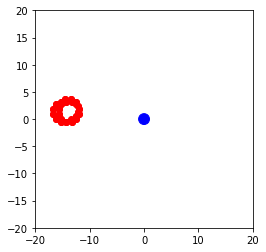

  0%|▏                                                                          | 997/500000 [00:11<2:35:18, 53.55it/s]

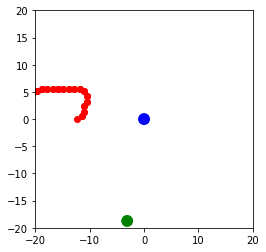

  0%|▎                                                                         | 1999/500000 [00:31<2:33:19, 54.13it/s]

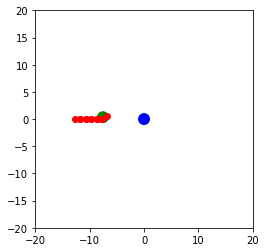

  1%|▍                                                                         | 2998/500000 [00:49<2:19:49, 59.24it/s]

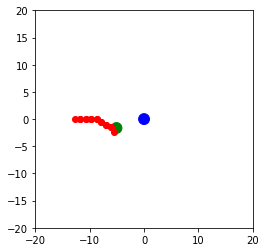

  1%|▌                                                                         | 3996/500000 [01:07<2:14:31, 61.45it/s]

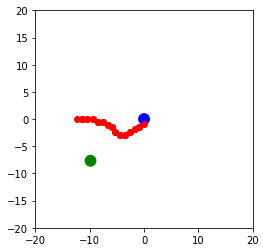

  1%|▋                                                                         | 4998/500000 [01:22<1:39:56, 82.55it/s]

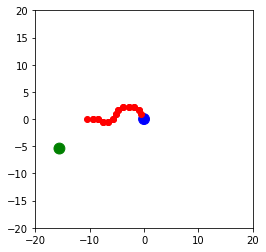

  1%|▉                                                                         | 5994/500000 [01:33<1:32:57, 88.58it/s]

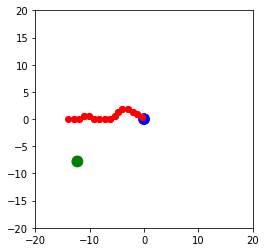

  1%|█                                                                         | 6991/500000 [01:44<1:31:04, 90.22it/s]

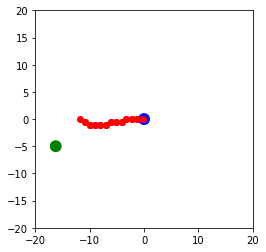

  2%|█▏                                                                        | 8000/500000 [01:56<1:49:26, 74.92it/s]

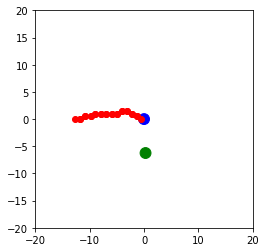

  2%|█▎                                                                        | 8992/500000 [02:08<1:25:37, 95.57it/s]

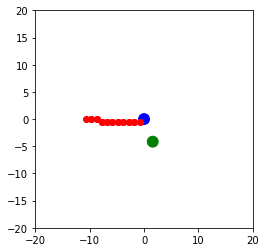

  2%|█▍                                                                        | 9993/500000 [02:19<1:43:48, 78.68it/s]

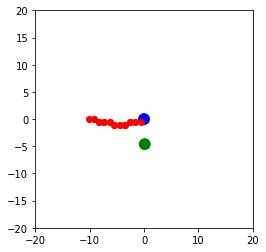

  2%|█▌                                                                       | 10994/500000 [02:31<1:35:01, 85.77it/s]

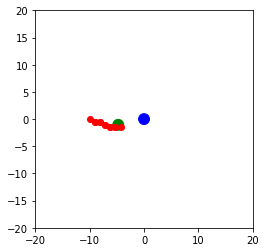

  2%|█▊                                                                       | 11999/500000 [02:45<1:40:56, 80.58it/s]

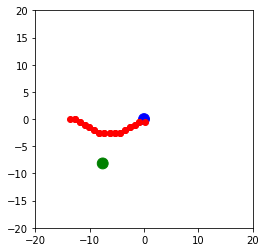

  3%|█▉                                                                       | 12995/500000 [02:57<1:35:40, 84.83it/s]

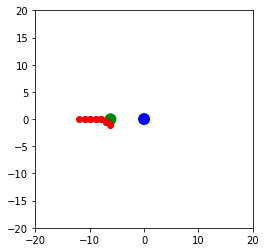

  3%|██                                                                       | 13994/500000 [03:08<1:24:24, 95.97it/s]

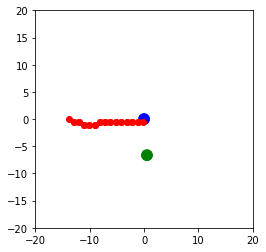

  3%|██▏                                                                      | 14997/500000 [03:19<1:35:43, 84.44it/s]

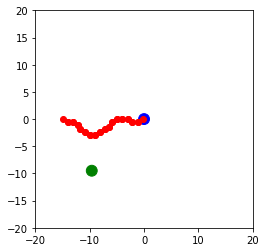

  3%|██▎                                                                      | 15998/500000 [03:31<1:26:16, 93.49it/s]

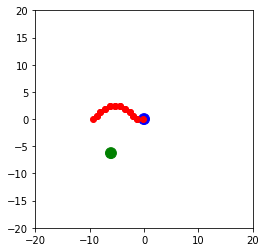

  3%|██▍                                                                      | 17000/500000 [03:43<1:48:37, 74.10it/s]

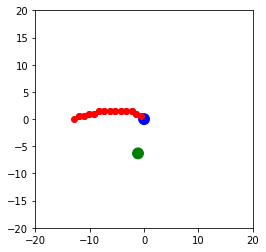

  4%|██▋                                                                      | 17998/500000 [03:56<1:39:02, 81.10it/s]

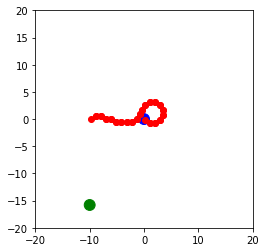

  4%|██▊                                                                      | 18994/500000 [04:07<1:24:37, 94.73it/s]

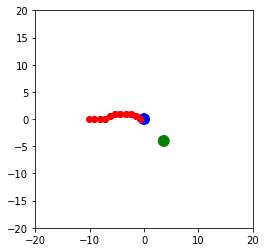

  4%|██▉                                                                      | 19998/500000 [04:18<1:37:46, 81.81it/s]

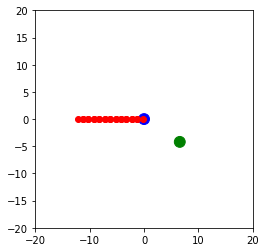

  4%|███                                                                      | 20999/500000 [04:29<1:33:26, 85.44it/s]

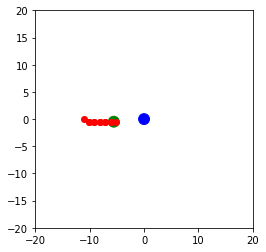

  4%|███▏                                                                     | 21994/500000 [04:40<1:26:36, 91.98it/s]

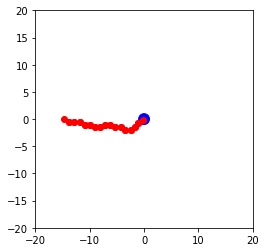

  5%|███▎                                                                     | 22995/500000 [04:51<1:29:22, 88.96it/s]

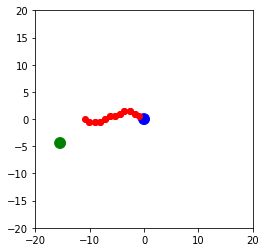

  5%|███▌                                                                     | 23995/500000 [05:03<1:30:36, 87.56it/s]

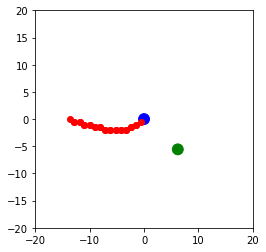

  5%|███▋                                                                     | 24996/500000 [05:14<1:26:17, 91.74it/s]

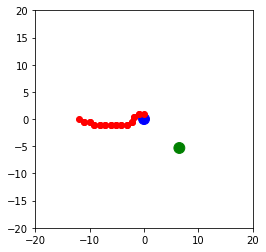

  5%|███▊                                                                     | 25997/500000 [05:25<1:24:26, 93.56it/s]

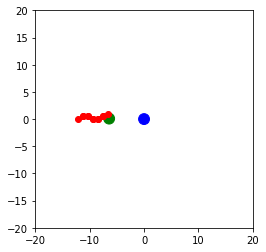

  5%|███▉                                                                     | 26992/500000 [05:36<1:24:57, 92.80it/s]

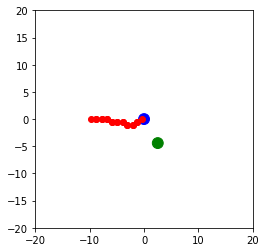

  6%|████                                                                     | 27995/500000 [05:47<1:35:49, 82.10it/s]

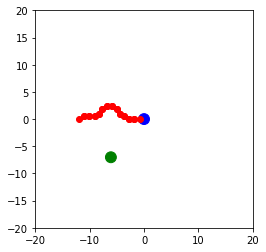

  6%|████▏                                                                    | 28991/500000 [05:59<1:30:38, 86.60it/s]

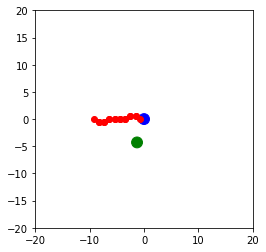

  6%|████▍                                                                    | 29999/500000 [06:11<1:33:35, 83.70it/s]

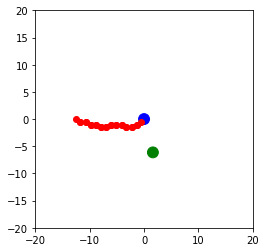

  6%|████▌                                                                    | 30992/500000 [06:22<1:29:23, 87.45it/s]

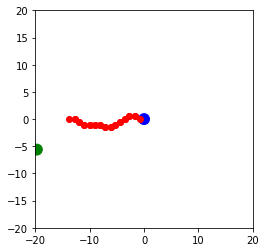

  6%|████▋                                                                    | 31992/500000 [06:34<1:24:24, 92.41it/s]

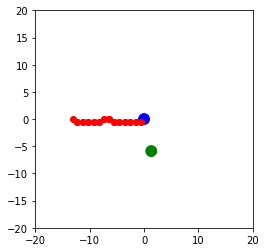

  7%|████▊                                                                    | 32990/500000 [06:45<1:22:51, 93.94it/s]

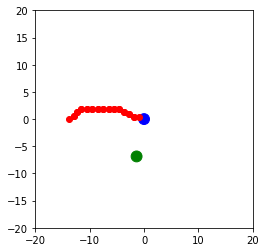

  7%|████▉                                                                    | 34000/500000 [06:59<2:13:33, 58.15it/s]

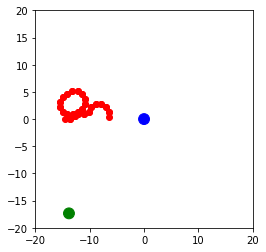

  7%|█████                                                                    | 34994/500000 [07:13<1:24:33, 91.65it/s]

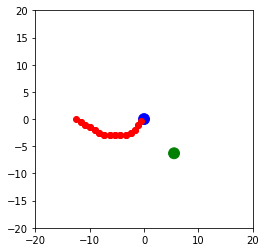

  7%|█████▎                                                                   | 35999/500000 [07:25<1:30:56, 85.04it/s]

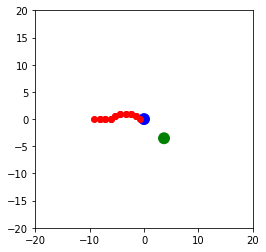

  7%|█████▍                                                                   | 37000/500000 [07:37<1:33:29, 82.54it/s]

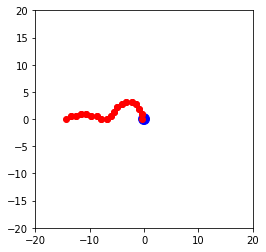

  8%|█████▌                                                                   | 37999/500000 [07:49<1:30:27, 85.12it/s]

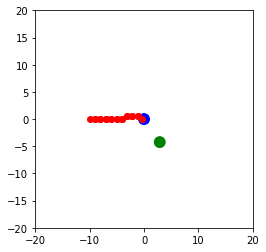

  8%|█████▋                                                                   | 38992/500000 [08:00<1:27:06, 88.21it/s]

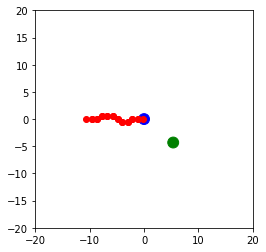

  8%|█████▊                                                                   | 39994/500000 [08:12<1:25:04, 90.12it/s]

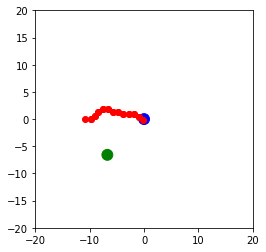

  8%|█████▉                                                                   | 40993/500000 [08:23<1:31:09, 83.92it/s]

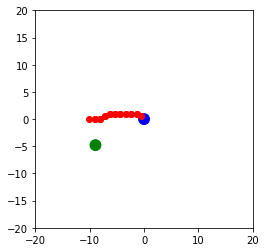

  8%|██████▏                                                                  | 42000/500000 [08:36<1:31:08, 83.75it/s]

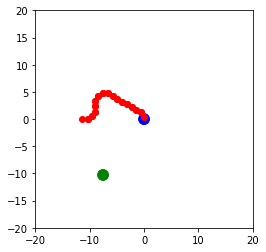

  9%|██████▎                                                                  | 42991/500000 [08:47<1:16:43, 99.28it/s]

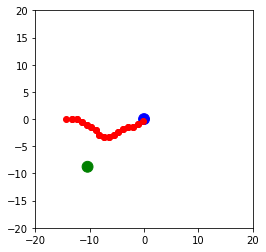

  9%|██████▍                                                                  | 43994/500000 [08:58<1:24:59, 89.43it/s]

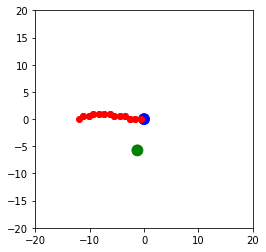

  9%|██████▌                                                                  | 44995/500000 [09:08<1:22:54, 91.47it/s]

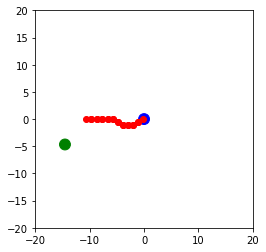

  9%|██████▋                                                                  | 45993/500000 [09:19<1:15:41, 99.97it/s]

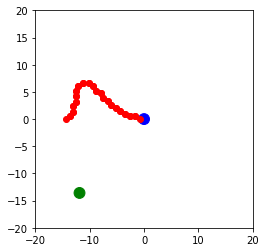

  9%|██████▊                                                                  | 46990/500000 [09:30<1:26:22, 87.42it/s]

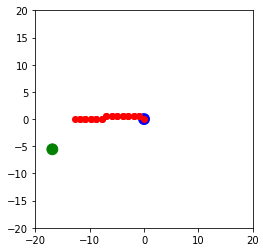

 10%|███████                                                                  | 47995/500000 [09:41<1:21:53, 91.99it/s]

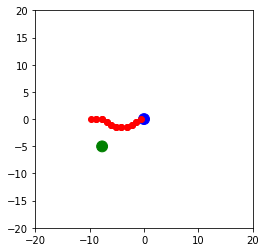

 10%|███████▏                                                                 | 48994/500000 [09:52<1:23:56, 89.54it/s]

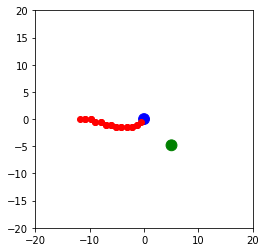

 10%|███████▎                                                                 | 49995/500000 [10:04<1:31:52, 81.64it/s]

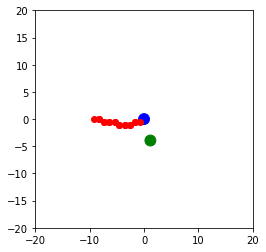

 10%|███████▍                                                                 | 50994/500000 [10:15<1:24:34, 88.48it/s]

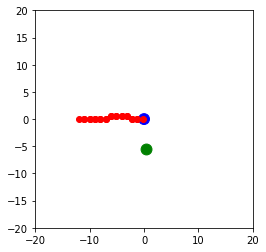

 10%|███████▌                                                                 | 51999/500000 [10:26<1:22:14, 90.80it/s]

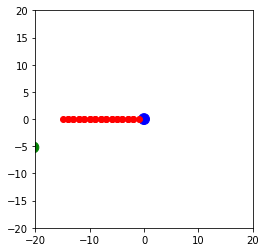

 11%|███████▋                                                                 | 52990/500000 [10:37<1:18:49, 94.52it/s]

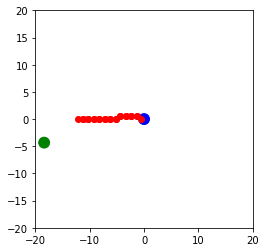

 11%|███████▉                                                                 | 53993/500000 [10:48<1:25:27, 86.99it/s]

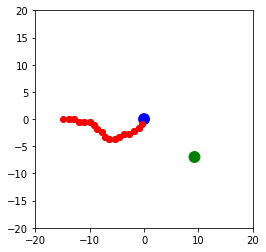

 11%|████████                                                                 | 54992/500000 [10:59<1:18:58, 93.91it/s]

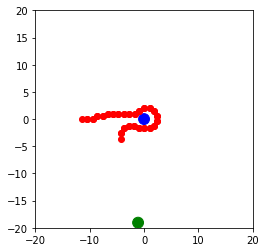

 11%|████████▏                                                                | 55997/500000 [11:10<1:18:23, 94.40it/s]

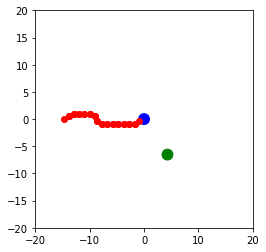

 11%|████████▎                                                                | 56991/500000 [11:21<1:15:55, 97.26it/s]

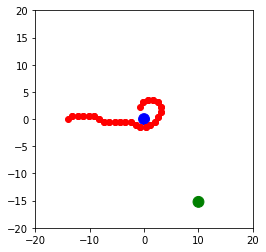

 12%|████████▍                                                                | 57998/500000 [11:32<1:17:13, 95.39it/s]

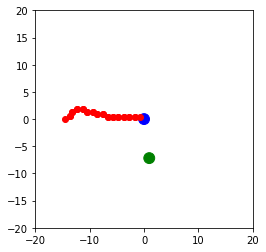

 12%|████████▌                                                                | 58998/500000 [11:43<1:24:57, 86.52it/s]

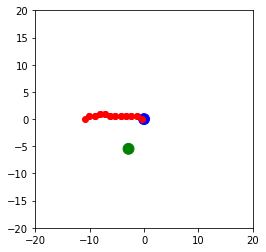

 12%|████████▊                                                                | 59995/500000 [11:54<1:17:24, 94.74it/s]

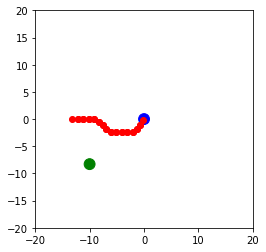

 12%|████████▉                                                                | 60998/500000 [12:06<1:19:55, 91.55it/s]

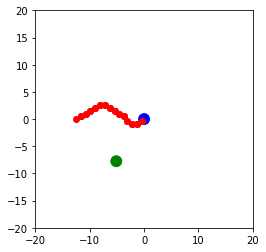

 12%|████████▉                                                               | 61998/500000 [12:17<1:10:14, 103.93it/s]

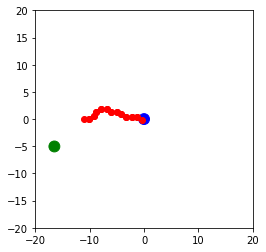

 13%|█████████▏                                                               | 62996/500000 [12:28<1:20:15, 90.75it/s]

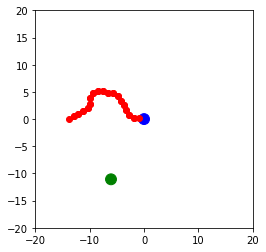

 13%|█████████▎                                                               | 63993/500000 [12:39<1:21:19, 89.36it/s]

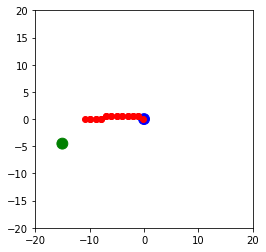

 13%|█████████▍                                                               | 64997/500000 [12:51<1:40:07, 72.40it/s]

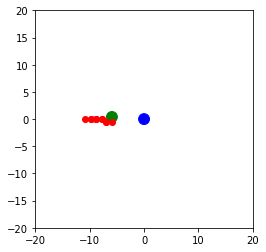

 13%|█████████▋                                                               | 65999/500000 [13:16<3:15:55, 36.92it/s]

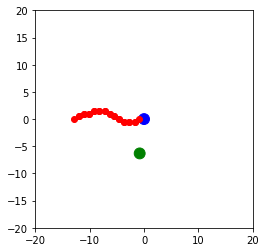

 13%|█████████▊                                                               | 66998/500000 [13:35<1:20:47, 89.32it/s]

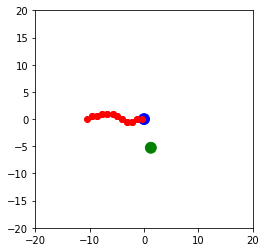

 14%|█████████▉                                                               | 67994/500000 [13:47<1:14:18, 96.90it/s]

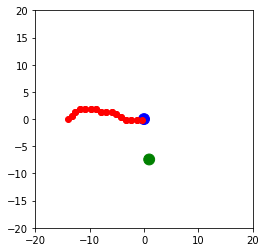

 14%|██████████                                                               | 68996/500000 [14:00<1:23:34, 85.95it/s]

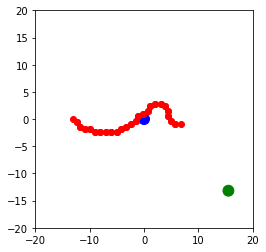

 14%|██████████▏                                                              | 69992/500000 [14:12<1:27:39, 81.76it/s]

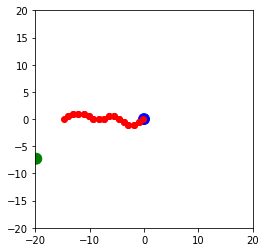

 14%|██████████▎                                                              | 71000/500000 [14:24<1:24:42, 84.41it/s]

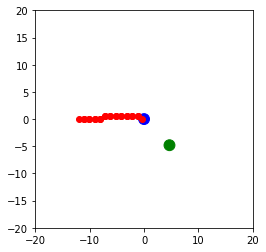

 14%|██████████▌                                                              | 71998/500000 [14:36<1:41:56, 69.98it/s]

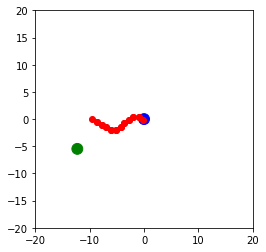

 15%|██████████▋                                                              | 72996/500000 [14:48<1:19:14, 89.81it/s]

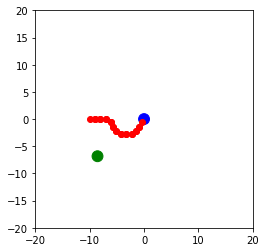

 15%|██████████▊                                                              | 73999/500000 [15:00<1:24:36, 83.92it/s]

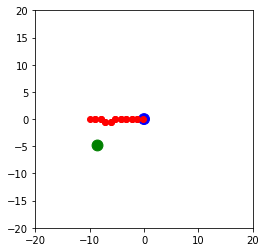

 15%|██████████▉                                                              | 74995/500000 [15:11<1:24:04, 84.25it/s]

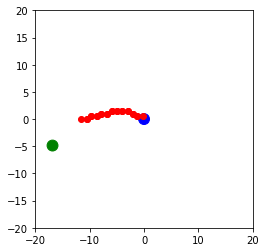

 15%|███████████                                                              | 75997/500000 [15:24<1:21:54, 86.28it/s]

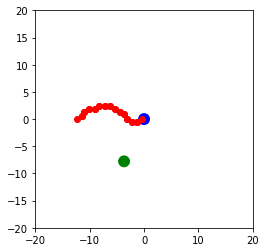

 15%|███████████▏                                                             | 76991/500000 [15:35<1:20:58, 87.07it/s]

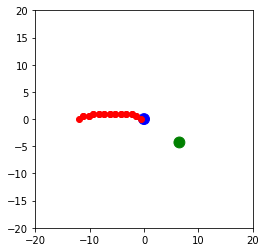

 16%|███████████▍                                                             | 77999/500000 [15:47<1:23:12, 84.52it/s]

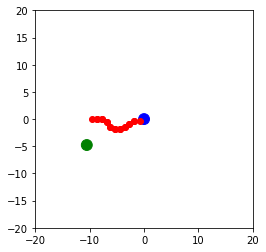

 16%|███████████▌                                                             | 78995/500000 [15:59<1:16:32, 91.67it/s]

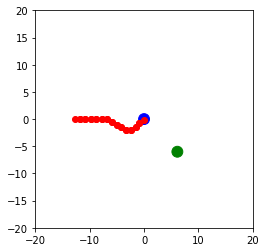

 16%|███████████▋                                                             | 79998/500000 [16:10<1:18:52, 88.75it/s]

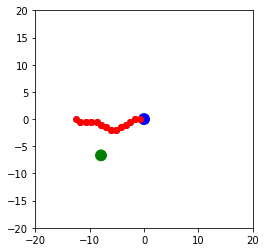

 16%|███████████▊                                                             | 80993/500000 [16:22<1:29:42, 77.84it/s]

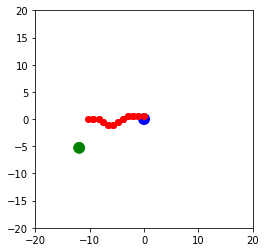

 16%|███████████▉                                                             | 81992/500000 [16:34<1:17:30, 89.89it/s]

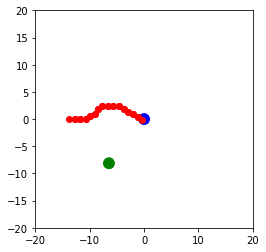

 17%|████████████                                                             | 82993/500000 [16:46<1:24:52, 81.89it/s]

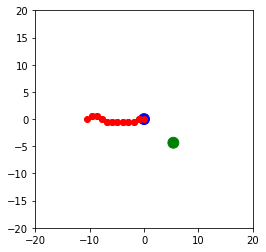

 17%|████████████▎                                                            | 83997/500000 [16:57<1:17:38, 89.30it/s]

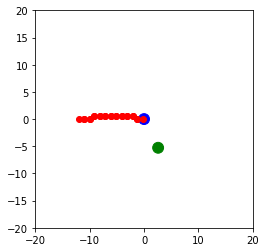

 17%|████████████▍                                                            | 84998/500000 [17:09<1:21:10, 85.21it/s]

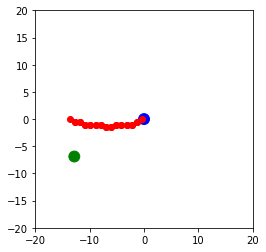

 17%|████████████▌                                                            | 85994/500000 [17:21<1:18:24, 88.00it/s]

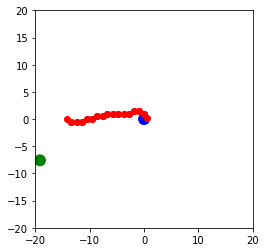

 17%|████████████▋                                                            | 86996/500000 [17:33<1:14:47, 92.04it/s]

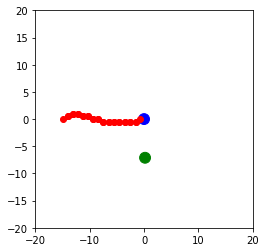

 18%|████████████▊                                                            | 87996/500000 [17:44<1:25:06, 80.68it/s]

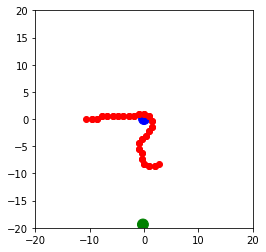

 18%|████████████▉                                                            | 88995/500000 [17:56<1:16:39, 89.36it/s]

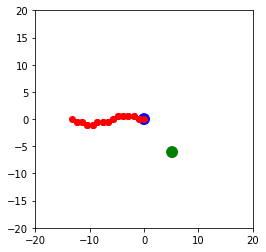

 18%|█████████████▏                                                           | 90000/500000 [18:08<1:27:41, 77.92it/s]

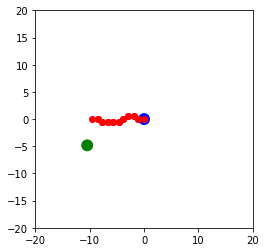

 18%|█████████████▎                                                           | 90997/500000 [18:20<1:21:54, 83.23it/s]

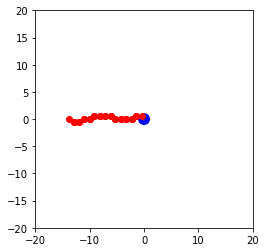

 18%|█████████████▍                                                           | 91996/500000 [18:32<1:23:40, 81.27it/s]

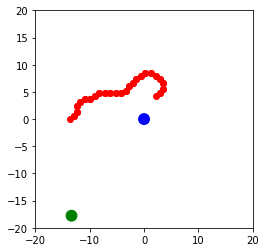

 19%|█████████████▌                                                           | 93000/500000 [18:44<1:21:28, 83.26it/s]

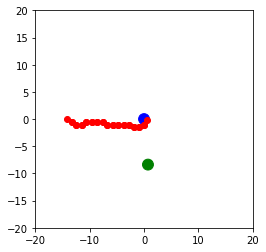

 19%|█████████████▋                                                           | 93992/500000 [18:56<1:15:38, 89.46it/s]

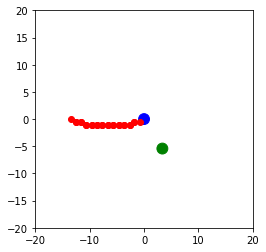

 19%|█████████████▊                                                           | 94993/500000 [19:08<1:17:41, 86.88it/s]

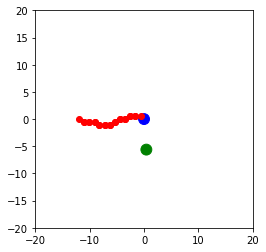

 19%|██████████████                                                           | 96000/500000 [19:20<1:18:10, 86.14it/s]

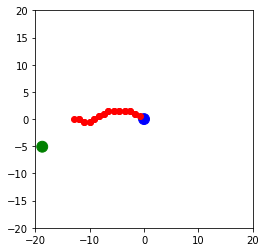

 19%|██████████████▏                                                          | 96992/500000 [19:31<1:19:44, 84.24it/s]

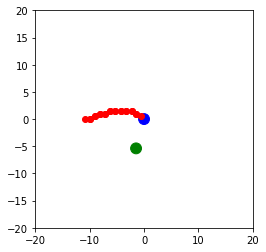

 20%|██████████████▎                                                          | 97996/500000 [19:43<1:17:29, 86.47it/s]

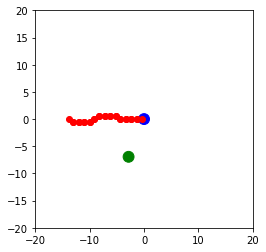

 20%|██████████████▍                                                          | 98999/500000 [19:55<1:14:43, 89.44it/s]

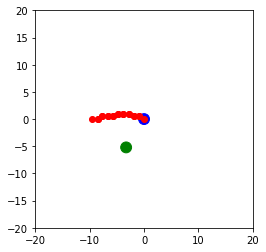

 20%|██████████████▌                                                          | 99993/500000 [20:06<1:16:18, 87.37it/s]

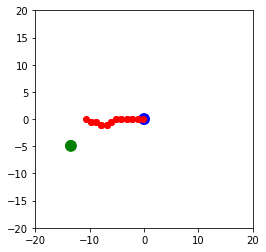

 20%|██████████████▌                                                         | 100999/500000 [20:18<1:18:44, 84.46it/s]

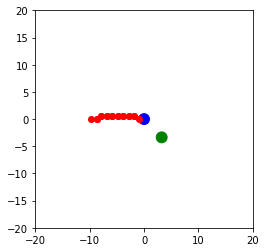

 20%|██████████████▋                                                         | 101992/500000 [20:29<1:17:35, 85.50it/s]

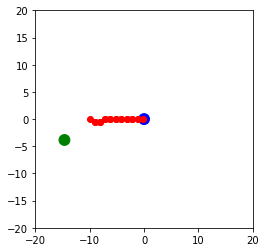

 21%|██████████████▊                                                         | 103000/500000 [20:41<1:22:00, 80.68it/s]

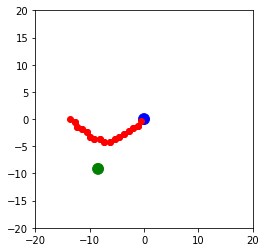

 21%|██████████████▉                                                         | 103992/500000 [20:53<1:17:09, 85.53it/s]

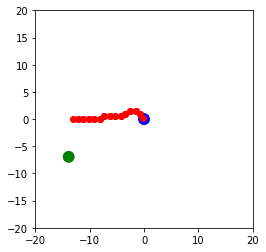

 21%|███████████████                                                         | 104997/500000 [21:05<1:17:45, 84.67it/s]

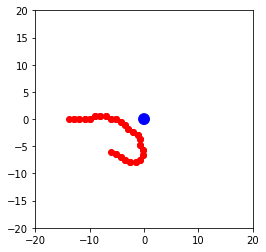

 21%|███████████████▎                                                        | 105994/500000 [21:17<1:17:58, 84.21it/s]

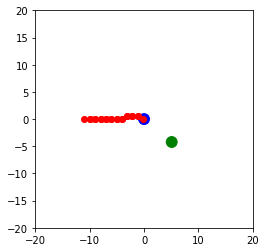

 21%|███████████████▍                                                        | 106997/500000 [21:29<1:19:05, 82.81it/s]

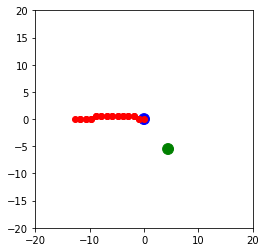

 22%|███████████████▌                                                        | 107993/500000 [21:41<1:14:11, 88.07it/s]

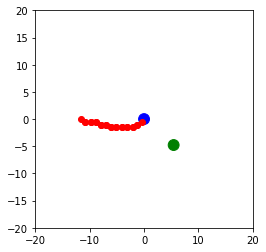

 22%|███████████████▋                                                        | 108998/500000 [21:52<1:13:09, 89.08it/s]

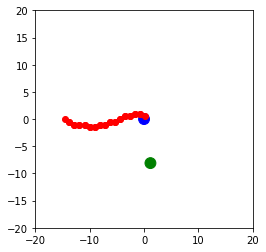

 22%|███████████████▊                                                        | 109991/500000 [22:03<1:10:47, 91.82it/s]

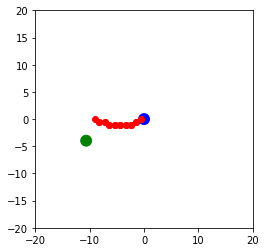

 22%|███████████████▉                                                        | 110998/500000 [22:15<1:17:04, 84.11it/s]

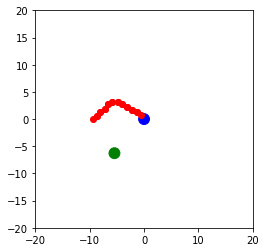

 22%|████████████████▏                                                       | 111994/500000 [22:27<1:15:57, 85.13it/s]

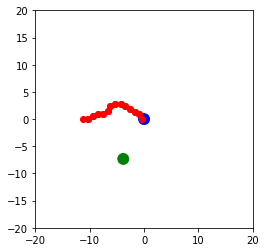

 23%|████████████████▎                                                       | 112992/500000 [22:38<1:14:27, 86.63it/s]

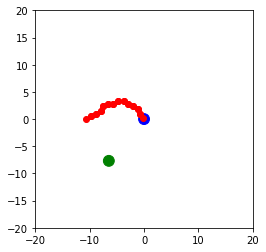

 23%|████████████████▍                                                       | 114000/500000 [22:50<1:12:18, 88.97it/s]

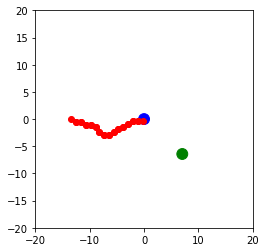

 23%|████████████████▌                                                       | 114992/500000 [23:02<1:14:49, 85.76it/s]

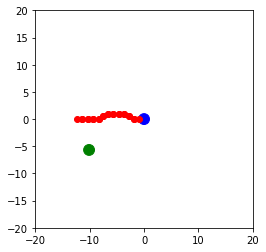

 23%|████████████████▋                                                       | 115996/500000 [23:14<1:11:55, 88.99it/s]

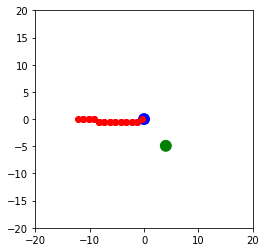

 23%|████████████████▊                                                       | 116998/500000 [23:26<1:12:04, 88.56it/s]

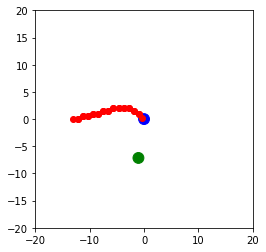

 24%|████████████████▉                                                       | 117996/500000 [23:37<1:11:40, 88.83it/s]

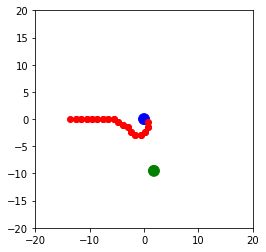

 24%|█████████████████▏                                                      | 118996/500000 [23:49<1:16:18, 83.21it/s]

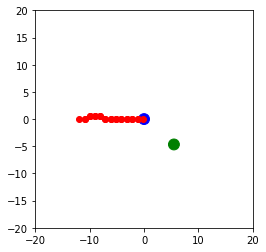

 24%|█████████████████▎                                                      | 119998/500000 [24:00<1:15:09, 84.26it/s]

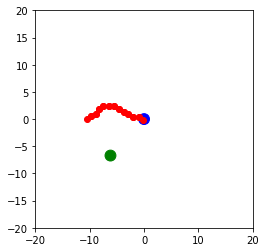

 24%|█████████████████▍                                                      | 120999/500000 [24:12<1:12:24, 87.23it/s]

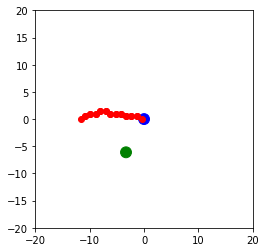

 24%|█████████████████▌                                                      | 121996/500000 [24:23<1:15:07, 83.85it/s]

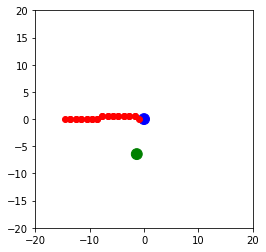

 25%|█████████████████▋                                                      | 122994/500000 [24:35<1:17:01, 81.59it/s]

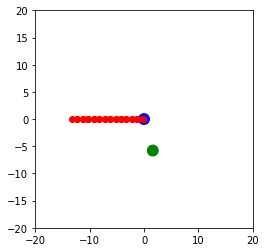

 25%|█████████████████▊                                                      | 123999/500000 [24:47<1:18:50, 79.48it/s]

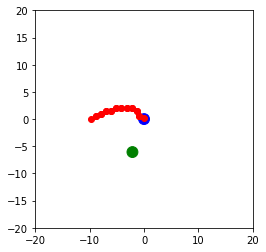

 25%|█████████████████▉                                                      | 124999/500000 [24:59<1:08:38, 91.06it/s]

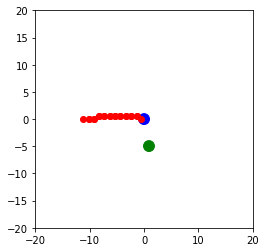

 25%|██████████████████▏                                                     | 125994/500000 [25:10<1:07:45, 91.99it/s]

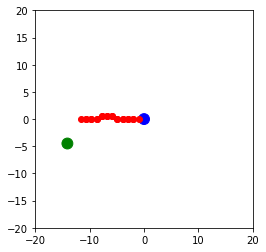

 25%|██████████████████▎                                                     | 126998/500000 [25:22<1:12:49, 85.37it/s]

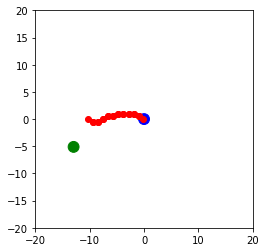

 26%|██████████████████▍                                                     | 127993/500000 [25:33<1:16:03, 81.52it/s]

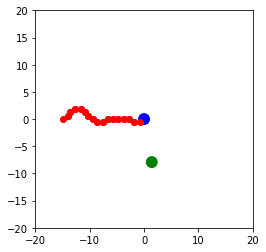

 26%|██████████████████▌                                                     | 128993/500000 [25:45<1:09:34, 88.87it/s]

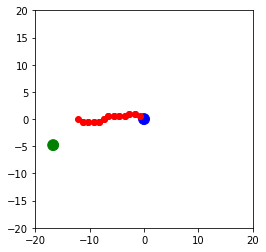

 26%|██████████████████▋                                                     | 130000/500000 [25:57<1:12:44, 84.78it/s]

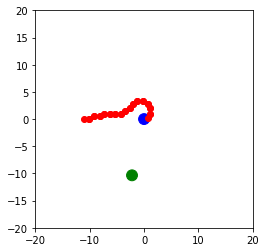

 26%|██████████████████▊                                                     | 130994/500000 [26:09<1:20:17, 76.59it/s]

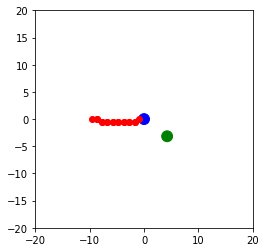

 26%|███████████████████                                                     | 131992/500000 [26:21<1:16:58, 79.68it/s]

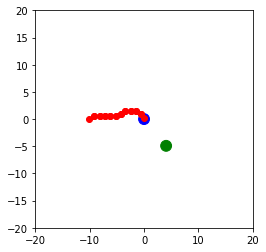

 27%|███████████████████▏                                                    | 132995/500000 [26:33<1:09:11, 88.40it/s]

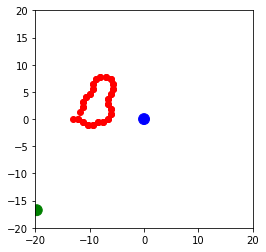

 27%|███████████████████▎                                                    | 134000/500000 [26:45<1:11:13, 85.63it/s]

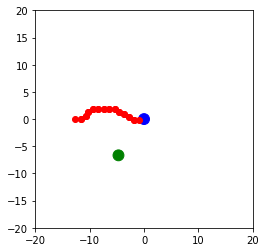

 27%|███████████████████▍                                                    | 135000/500000 [26:56<1:07:25, 90.22it/s]

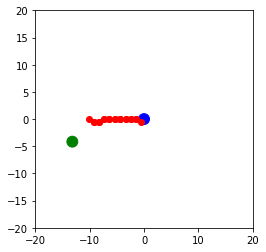

 27%|███████████████████▌                                                    | 135999/500000 [27:08<1:09:20, 87.48it/s]

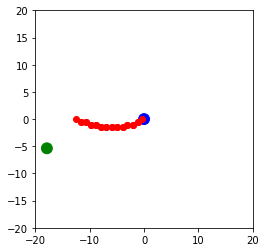

 27%|███████████████████▋                                                    | 136997/500000 [27:20<1:10:37, 85.66it/s]

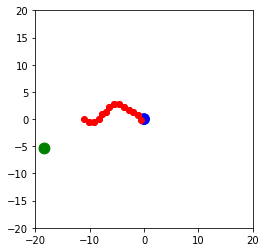

 28%|███████████████████▊                                                    | 137993/500000 [27:31<1:12:38, 83.06it/s]

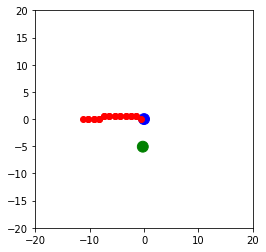

 28%|████████████████████                                                    | 138995/500000 [27:43<1:07:41, 88.89it/s]

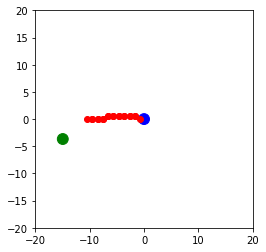

 28%|████████████████████▏                                                   | 139996/500000 [27:55<1:11:28, 83.94it/s]

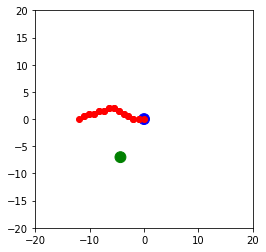

 28%|████████████████████▎                                                   | 140993/500000 [28:06<1:12:37, 82.38it/s]

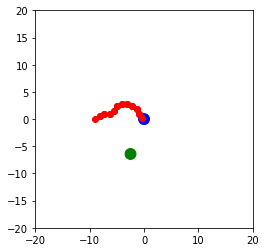

 28%|████████████████████▍                                                   | 141998/500000 [28:19<1:10:08, 85.07it/s]

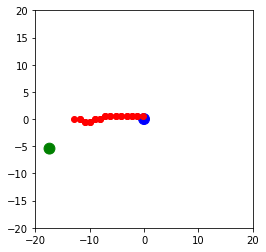

 29%|████████████████████▌                                                   | 142993/500000 [28:30<1:14:37, 79.74it/s]

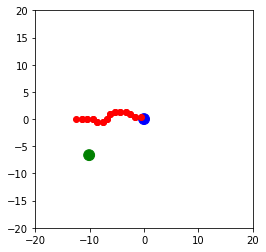

 29%|████████████████████▋                                                   | 143992/500000 [28:42<1:10:30, 84.15it/s]

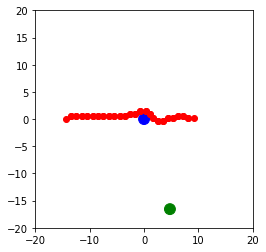

 29%|████████████████████▉                                                   | 144993/500000 [28:54<1:08:50, 85.95it/s]

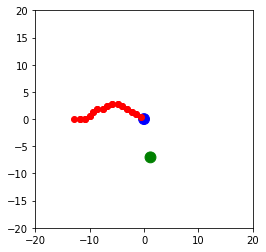

 29%|█████████████████████                                                   | 145995/500000 [29:06<1:11:16, 82.79it/s]

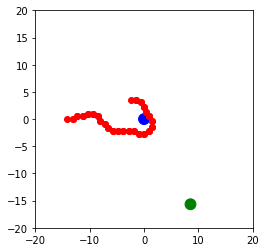

 29%|█████████████████████▏                                                  | 146993/500000 [29:17<1:09:32, 84.61it/s]

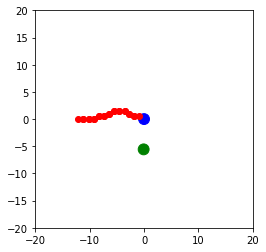

 30%|█████████████████████▎                                                  | 147997/500000 [29:29<1:09:38, 84.23it/s]

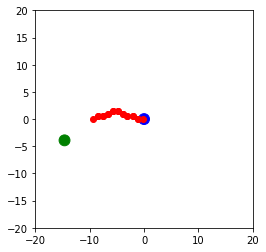

 30%|█████████████████████▍                                                  | 148999/500000 [29:41<1:03:39, 91.91it/s]

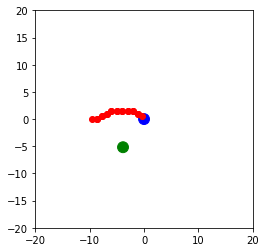

 30%|█████████████████████▌                                                  | 149995/500000 [29:52<1:11:08, 81.99it/s]

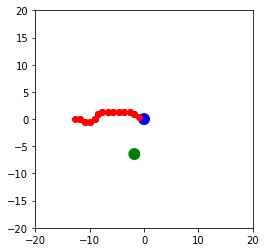

 30%|█████████████████████▋                                                  | 150996/500000 [30:04<1:08:28, 84.95it/s]

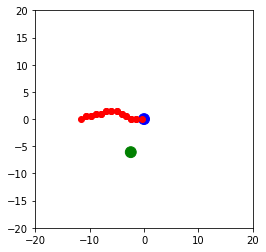

 30%|█████████████████████▉                                                  | 151999/500000 [30:16<1:02:52, 92.25it/s]

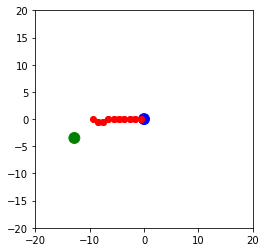

 31%|██████████████████████                                                  | 152997/500000 [30:27<1:09:21, 83.38it/s]

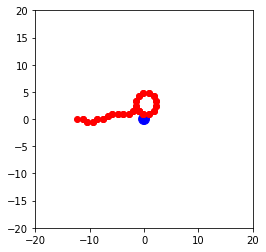

 31%|██████████████████████▏                                                 | 153995/500000 [30:39<1:01:59, 93.03it/s]

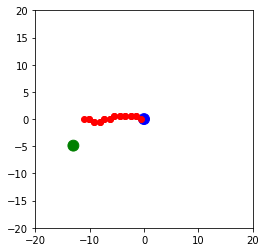

 31%|██████████████████████▎                                                 | 154994/500000 [30:50<1:07:51, 84.74it/s]

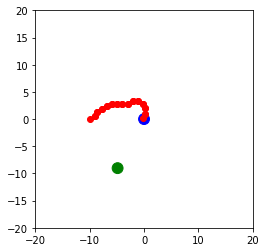

 31%|██████████████████████▍                                                 | 155996/500000 [31:02<1:04:27, 88.95it/s]

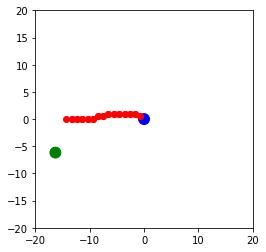

 31%|██████████████████████▌                                                 | 156993/500000 [31:13<1:11:53, 79.52it/s]

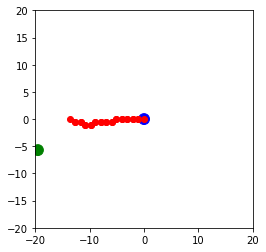

 32%|██████████████████████▊                                                 | 157994/500000 [31:25<1:12:25, 78.71it/s]

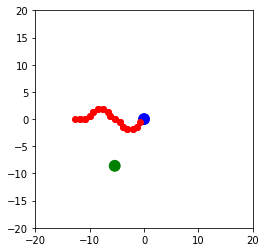

 32%|██████████████████████▉                                                 | 158998/500000 [31:37<1:06:54, 84.94it/s]

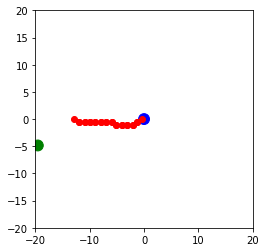

 32%|███████████████████████                                                 | 159998/500000 [31:48<1:02:07, 91.22it/s]

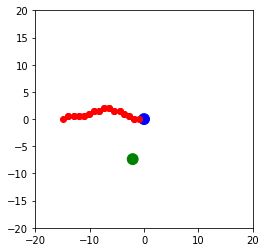

 32%|███████████████████████▏                                                | 160992/500000 [32:00<1:01:48, 91.40it/s]

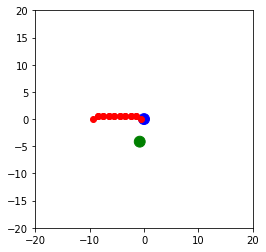

 32%|███████████████████████▎                                                | 161993/500000 [32:12<1:03:35, 88.59it/s]

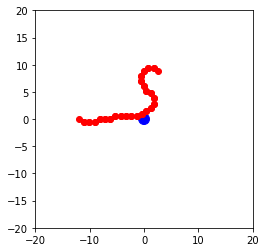

 33%|███████████████████████▍                                                | 162997/500000 [32:23<1:05:43, 85.45it/s]

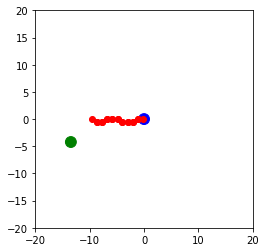

 33%|███████████████████████▌                                                | 163995/500000 [32:35<1:22:37, 67.78it/s]

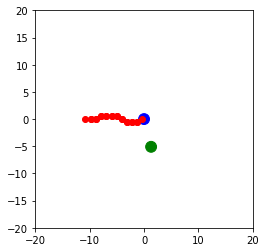

 33%|███████████████████████▊                                                | 164994/500000 [32:46<1:03:53, 87.39it/s]

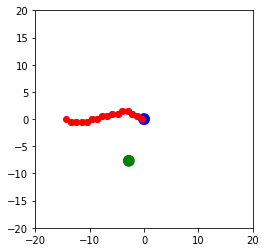

 33%|███████████████████████▉                                                | 165997/500000 [32:58<1:01:01, 91.23it/s]

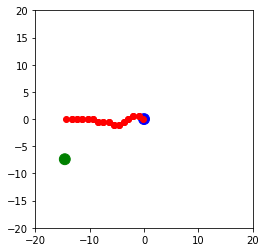

 33%|████████████████████████                                                | 166994/500000 [33:09<1:01:14, 90.62it/s]

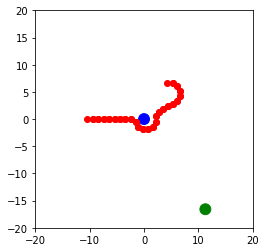

 34%|████████████████████████▏                                               | 167994/500000 [33:21<1:03:33, 87.05it/s]

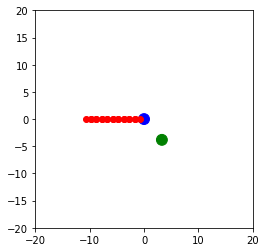

 34%|████████████████████████▎                                               | 168991/500000 [33:32<1:00:29, 91.19it/s]

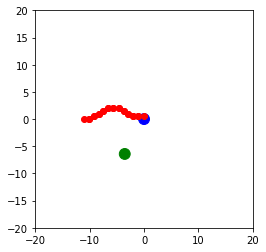

 34%|████████████████████████▍                                               | 170000/500000 [33:44<1:05:06, 84.46it/s]

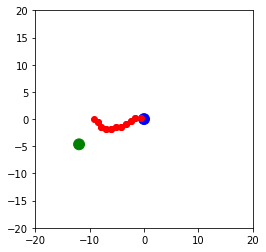

 34%|█████████████████████████▎                                                | 170993/500000 [33:56<59:09, 92.68it/s]

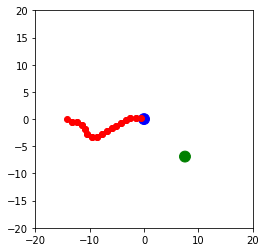

 34%|████████████████████████▊                                               | 171992/500000 [34:08<1:02:48, 87.05it/s]

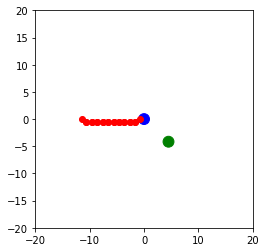

 35%|████████████████████████▉                                               | 172996/500000 [34:19<1:02:56, 86.58it/s]

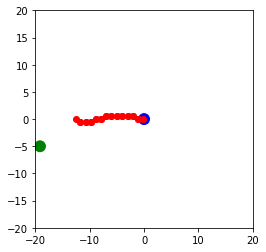

 35%|█████████████████████████                                               | 174000/500000 [34:31<1:05:00, 83.58it/s]

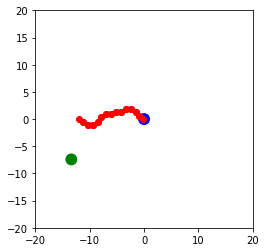

 35%|█████████████████████████▏                                              | 174995/500000 [34:42<1:00:38, 89.32it/s]

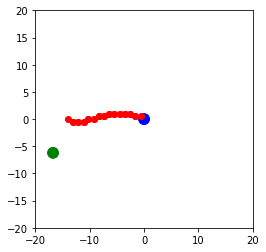

 35%|██████████████████████████                                                | 175993/500000 [34:54<58:29, 92.32it/s]

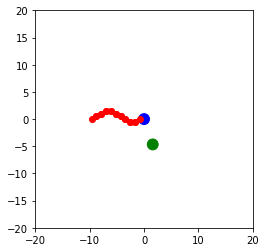

 35%|█████████████████████████▍                                              | 176999/500000 [35:05<1:03:57, 84.18it/s]

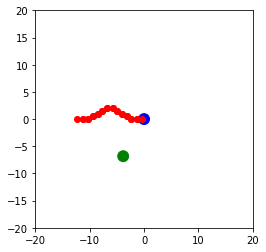

 36%|█████████████████████████▋                                              | 177998/500000 [35:17<1:00:33, 88.63it/s]

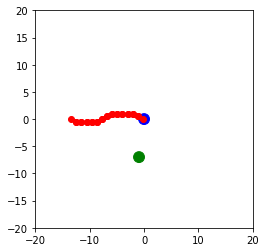

 36%|██████████████████████████▍                                               | 178997/500000 [35:29<55:52, 95.74it/s]

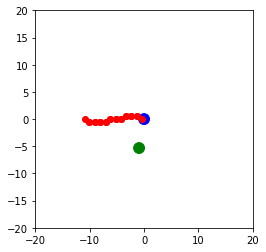

 36%|█████████████████████████▉                                              | 179996/500000 [35:40<1:02:10, 85.77it/s]

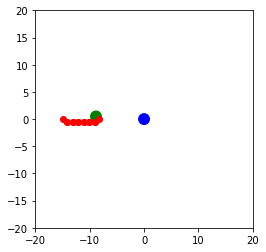

 36%|██████████████████████████                                              | 180992/500000 [35:53<1:02:41, 84.81it/s]

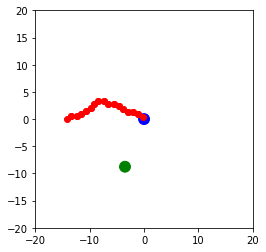

 36%|██████████████████████████▏                                             | 181998/500000 [36:04<1:00:36, 87.45it/s]

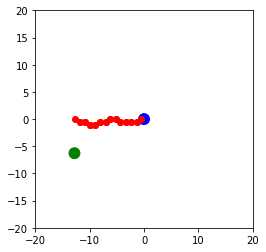

 37%|███████████████████████████                                               | 182995/500000 [36:16<58:53, 89.73it/s]

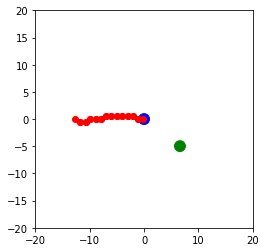

 37%|██████████████████████████▍                                             | 183997/500000 [36:28<1:03:55, 82.40it/s]

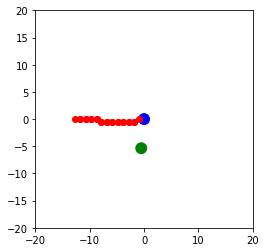

 37%|███████████████████████████▍                                              | 185000/500000 [36:40<56:58, 92.15it/s]

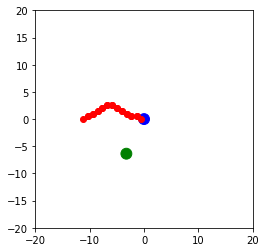

 37%|███████████████████████████▌                                              | 185998/500000 [36:51<57:33, 90.91it/s]

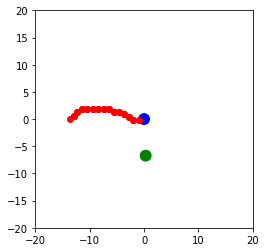

 37%|██████████████████████████▉                                             | 186997/500000 [37:03<1:02:46, 83.09it/s]

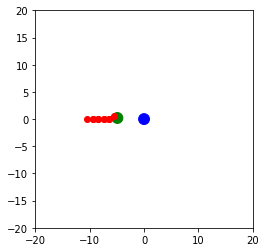

 38%|███████████████████████████                                             | 187992/500000 [37:14<1:01:06, 85.11it/s]

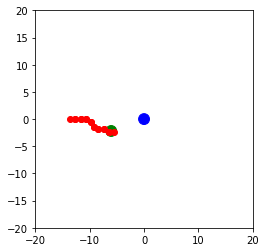

 38%|███████████████████████████▉                                              | 188992/500000 [37:26<57:57, 89.43it/s]

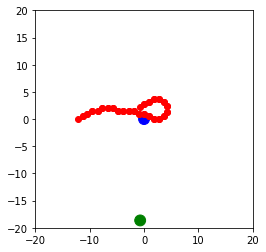

 38%|███████████████████████████▎                                            | 189993/500000 [37:38<1:00:12, 85.82it/s]

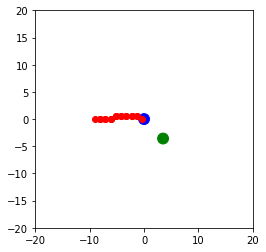

 38%|███████████████████████████▌                                            | 190995/500000 [37:49<1:00:06, 85.68it/s]

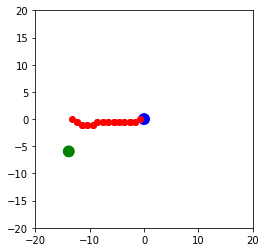

 38%|███████████████████████████▋                                            | 191994/500000 [38:01<1:00:11, 85.28it/s]

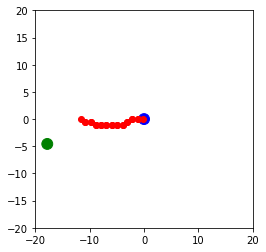

 39%|████████████████████████████▌                                             | 192994/500000 [38:12<58:54, 86.86it/s]

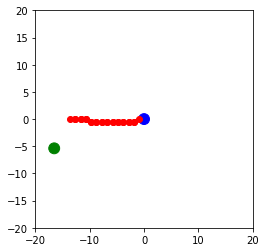

 39%|███████████████████████████▉                                            | 193997/500000 [38:24<1:00:09, 84.77it/s]

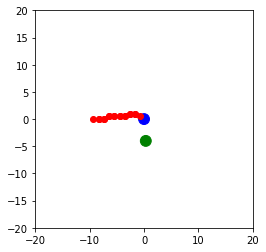

 39%|████████████████████████████▊                                             | 194999/500000 [38:36<58:04, 87.53it/s]

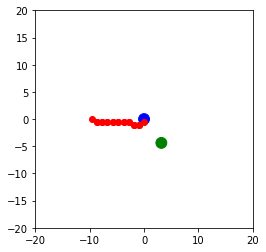

 39%|████████████████████████████▏                                           | 196000/500000 [38:48<1:01:08, 82.87it/s]

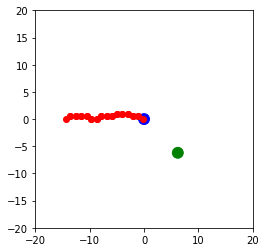

 39%|█████████████████████████████▏                                            | 196997/500000 [38:59<56:31, 89.35it/s]

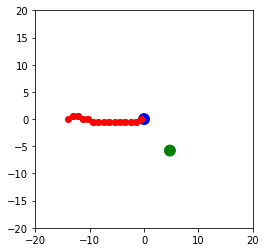

 40%|█████████████████████████████▎                                            | 197998/500000 [39:11<58:25, 86.15it/s]

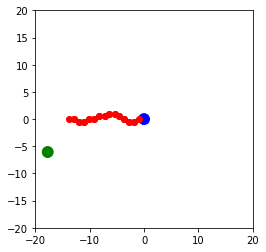

 40%|█████████████████████████████▍                                            | 198995/500000 [39:22<58:37, 85.58it/s]

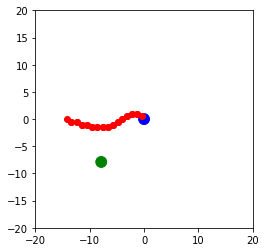

 40%|█████████████████████████████▌                                            | 199998/500000 [39:34<55:59, 89.31it/s]

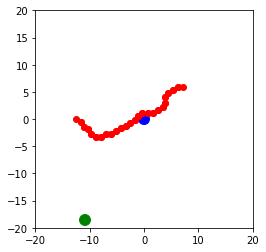

 40%|█████████████████████████████▋                                            | 200995/500000 [39:45<54:58, 90.65it/s]

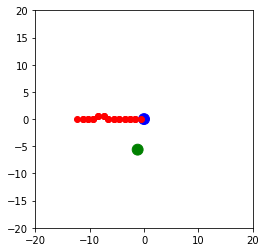

 40%|█████████████████████████████                                           | 201994/500000 [39:58<1:03:17, 78.48it/s]

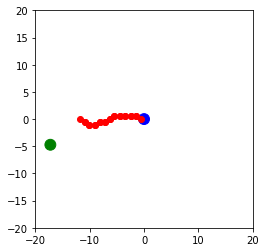

 41%|██████████████████████████████                                            | 202999/500000 [40:09<56:27, 87.66it/s]

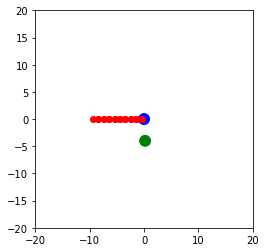

 41%|██████████████████████████████▏                                           | 203999/500000 [40:21<55:00, 89.69it/s]

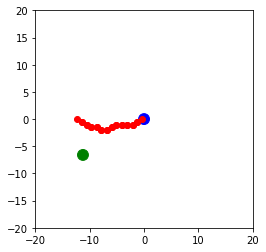

 41%|██████████████████████████████▎                                           | 204992/500000 [40:33<55:31, 88.56it/s]

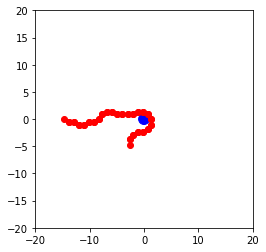

 41%|██████████████████████████████▍                                           | 205993/500000 [40:45<54:19, 90.21it/s]

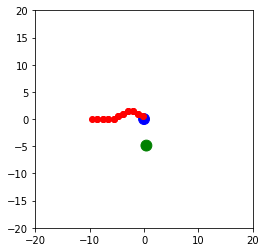

 41%|██████████████████████████████▋                                           | 206999/500000 [40:57<58:54, 82.91it/s]

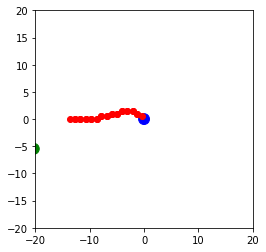

 42%|██████████████████████████████▊                                           | 207991/500000 [41:09<50:52, 95.66it/s]

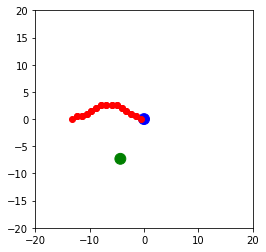

 42%|██████████████████████████████▉                                           | 208992/500000 [41:20<58:33, 82.82it/s]

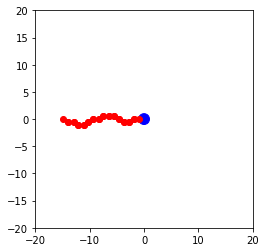

 42%|███████████████████████████████                                           | 209997/500000 [41:32<53:09, 90.92it/s]

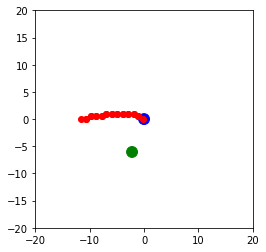

 42%|███████████████████████████████▏                                          | 210999/500000 [41:43<52:26, 91.86it/s]

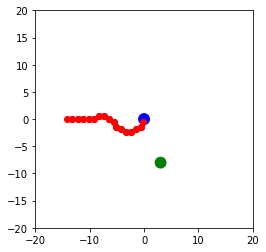

 42%|███████████████████████████████▍                                          | 211998/500000 [41:55<54:58, 87.32it/s]

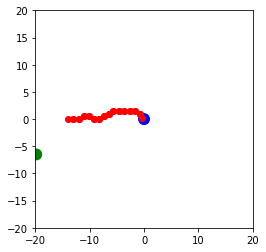

 43%|███████████████████████████████▌                                          | 212992/500000 [42:06<58:35, 81.63it/s]

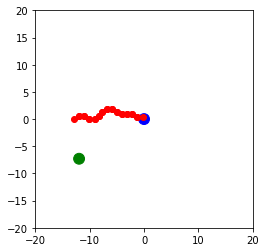

 43%|███████████████████████████████▋                                          | 213993/500000 [42:18<53:45, 88.66it/s]

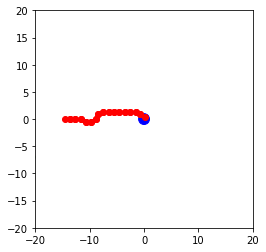

 43%|███████████████████████████████▊                                          | 214994/500000 [42:30<54:31, 87.12it/s]

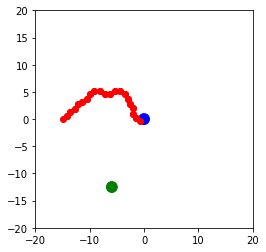

 43%|███████████████████████████████▉                                          | 216000/500000 [42:41<55:52, 84.71it/s]

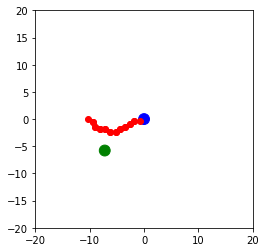

 43%|████████████████████████████████                                          | 216995/500000 [42:53<51:46, 91.10it/s]

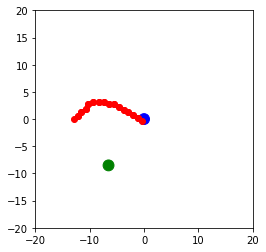

 44%|████████████████████████████████▎                                         | 217997/500000 [43:04<53:22, 88.06it/s]

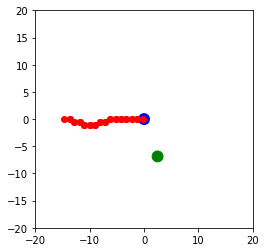

 44%|████████████████████████████████▍                                         | 218995/500000 [43:16<50:41, 92.38it/s]

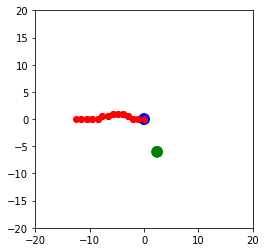

 44%|████████████████████████████████▌                                         | 219993/500000 [43:27<53:30, 87.21it/s]

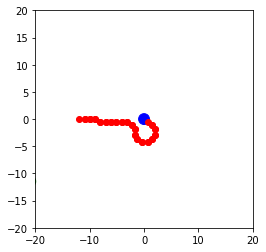

 44%|████████████████████████████████▋                                         | 220994/500000 [43:39<49:40, 93.61it/s]

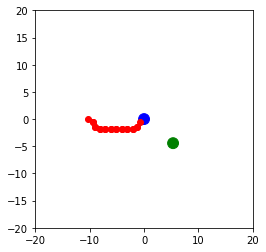

 44%|████████████████████████████████▊                                         | 221996/500000 [43:51<54:30, 85.00it/s]

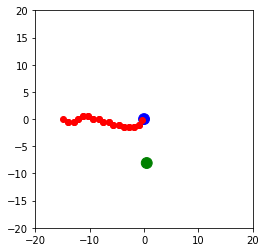

 45%|█████████████████████████████████                                         | 222995/500000 [44:02<53:12, 86.77it/s]

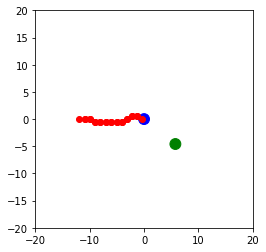

 45%|█████████████████████████████████▏                                        | 223991/500000 [44:14<52:38, 87.39it/s]

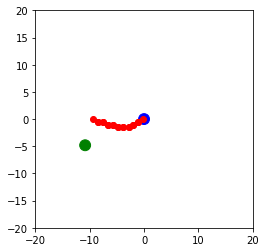

 45%|█████████████████████████████████▎                                        | 224999/500000 [44:25<50:59, 89.88it/s]

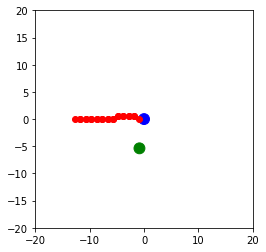

 45%|█████████████████████████████████▍                                        | 225997/500000 [44:37<56:08, 81.34it/s]

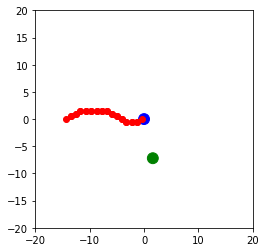

 45%|█████████████████████████████████▌                                        | 227000/500000 [44:49<55:18, 82.26it/s]

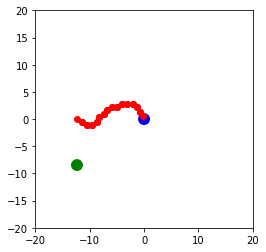

 46%|█████████████████████████████████▋                                        | 227994/500000 [45:00<53:34, 84.62it/s]

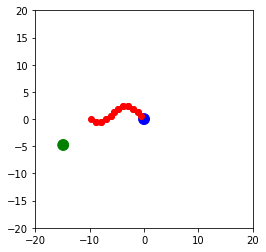

 46%|█████████████████████████████████▉                                        | 228998/500000 [45:12<57:21, 78.75it/s]

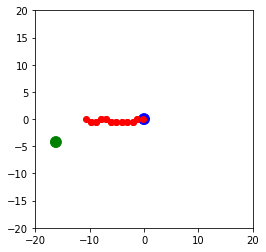

 46%|██████████████████████████████████                                        | 229992/500000 [45:23<52:56, 85.00it/s]

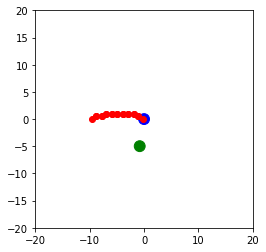

 46%|██████████████████████████████████▏                                       | 230996/500000 [45:35<50:50, 88.19it/s]

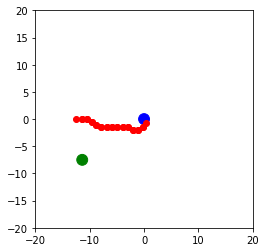

 46%|██████████████████████████████████▎                                       | 231995/500000 [45:46<51:30, 86.72it/s]

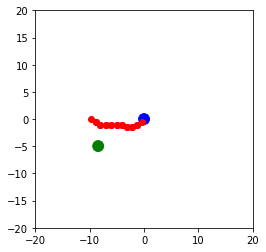

 47%|██████████████████████████████████▍                                       | 232998/500000 [45:58<53:47, 82.72it/s]

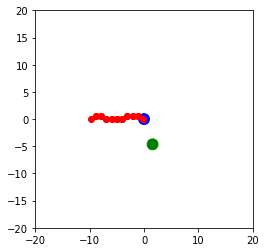

 47%|██████████████████████████████████▋                                       | 234000/500000 [46:10<50:40, 87.48it/s]

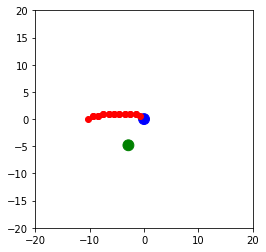

 47%|██████████████████████████████████▊                                       | 234994/500000 [46:21<53:28, 82.59it/s]

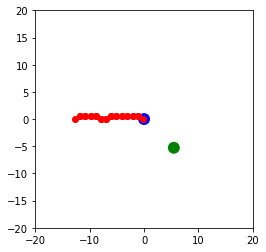

 47%|██████████████████████████████████▉                                       | 235999/500000 [46:33<50:42, 86.77it/s]

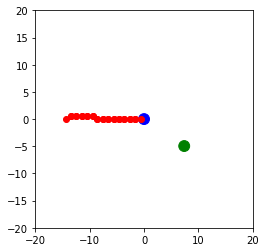

 47%|███████████████████████████████████                                       | 236999/500000 [46:45<52:52, 82.90it/s]

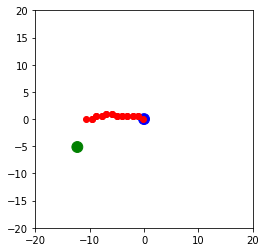

 48%|███████████████████████████████████▏                                      | 237996/500000 [46:56<51:28, 84.84it/s]

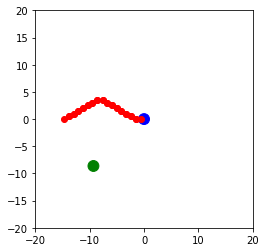

 48%|███████████████████████████████████▎                                      | 239000/500000 [47:08<53:36, 81.14it/s]

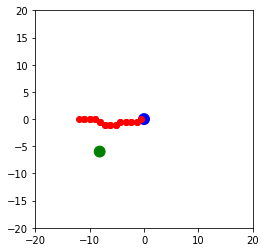

 48%|███████████████████████████████████▌                                      | 239995/500000 [47:19<50:34, 85.69it/s]

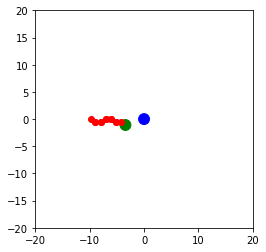

 48%|███████████████████████████████████▋                                      | 240994/500000 [47:31<48:24, 89.18it/s]

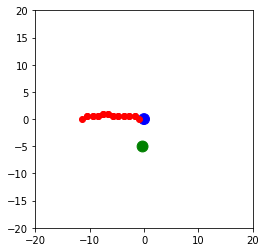

 48%|███████████████████████████████████▊                                      | 241999/500000 [47:43<50:32, 85.08it/s]

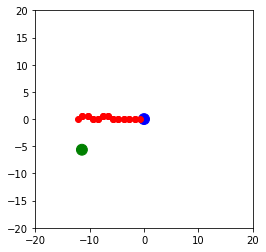

 49%|███████████████████████████████████▉                                      | 243000/500000 [47:54<46:08, 92.83it/s]

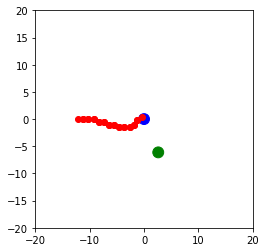

 49%|████████████████████████████████████                                      | 243999/500000 [48:05<45:48, 93.15it/s]

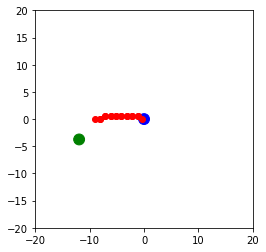

 49%|████████████████████████████████████▎                                     | 244996/500000 [48:17<49:27, 85.94it/s]

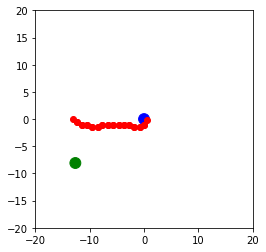

 49%|████████████████████████████████████▍                                     | 245990/500000 [48:29<51:24, 82.36it/s]

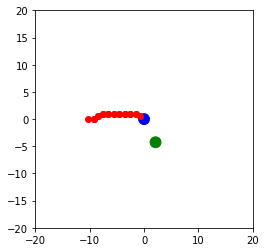

 49%|████████████████████████████████████▌                                     | 246999/500000 [48:41<49:46, 84.71it/s]

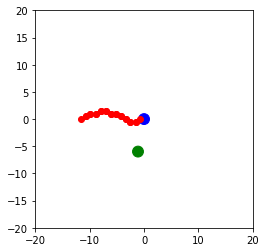

 50%|████████████████████████████████████▋                                     | 247993/500000 [48:52<49:49, 84.31it/s]

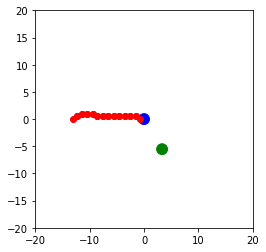

 50%|████████████████████████████████████▊                                     | 248996/500000 [49:04<45:00, 92.95it/s]

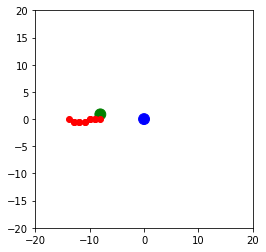

 50%|████████████████████████████████████▉                                     | 249994/500000 [49:15<49:01, 84.99it/s]

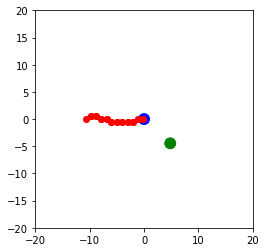

 50%|█████████████████████████████████████▏                                    | 250994/500000 [49:26<45:48, 90.60it/s]

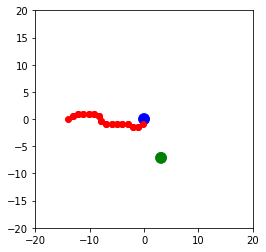

 50%|█████████████████████████████████████▎                                    | 251994/500000 [49:38<45:54, 90.04it/s]

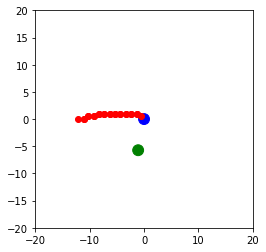

 51%|█████████████████████████████████████▍                                    | 252991/500000 [49:49<45:31, 90.44it/s]

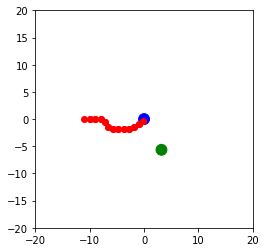

 51%|█████████████████████████████████████▌                                    | 253995/500000 [50:01<49:10, 83.38it/s]

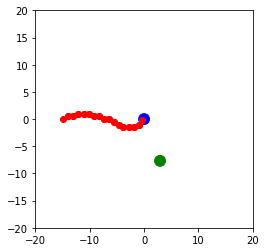

 51%|█████████████████████████████████████▋                                    | 254993/500000 [50:12<46:00, 88.76it/s]

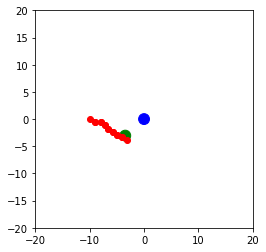

 51%|█████████████████████████████████████▉                                    | 255995/500000 [50:23<45:30, 89.37it/s]

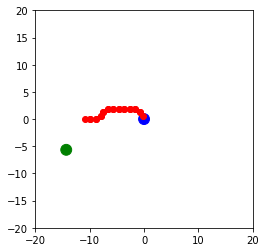

 51%|██████████████████████████████████████                                    | 256998/500000 [50:34<43:55, 92.19it/s]

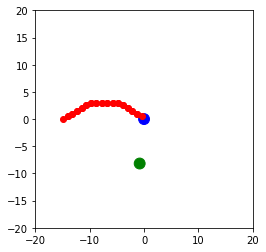

 52%|██████████████████████████████████████▏                                   | 257995/500000 [50:46<44:11, 91.27it/s]

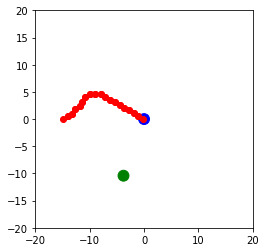

 52%|██████████████████████████████████████▎                                   | 258993/500000 [50:57<49:55, 80.46it/s]

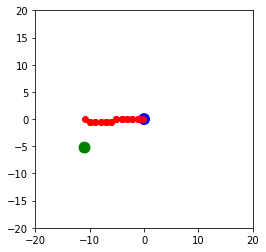

 52%|██████████████████████████████████████▍                                   | 259995/500000 [51:09<49:45, 80.40it/s]

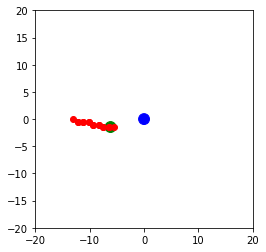

 52%|██████████████████████████████████████▋                                   | 260995/500000 [51:20<46:40, 85.36it/s]

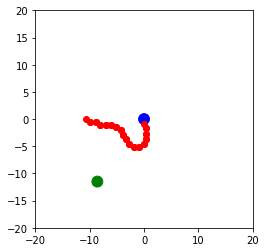

 52%|██████████████████████████████████████▊                                   | 262000/500000 [51:32<44:31, 89.09it/s]

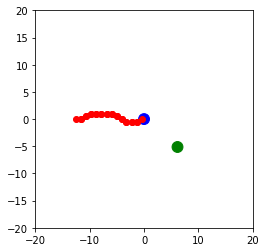

 53%|██████████████████████████████████████▉                                   | 262997/500000 [51:43<44:21, 89.04it/s]

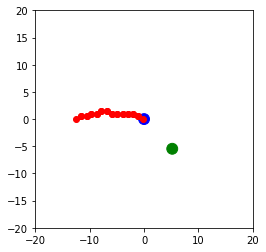

 53%|███████████████████████████████████████                                   | 263995/500000 [51:54<43:27, 90.50it/s]

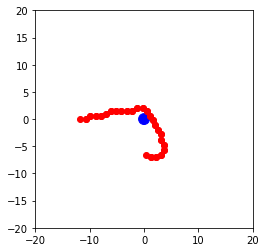

 53%|███████████████████████████████████████▏                                  | 264998/500000 [52:06<42:47, 91.52it/s]

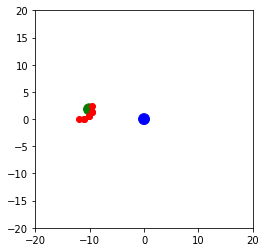

 53%|███████████████████████████████████████▎                                  | 266000/500000 [52:18<45:55, 84.92it/s]

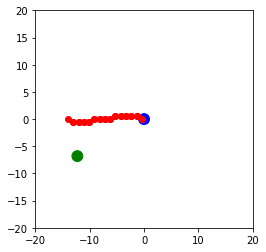

 53%|███████████████████████████████████████▌                                  | 266994/500000 [52:29<41:22, 93.85it/s]

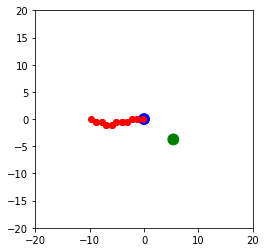

 54%|███████████████████████████████████████▋                                  | 267993/500000 [52:40<41:06, 94.06it/s]

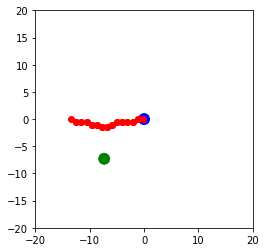

 54%|███████████████████████████████████████▊                                  | 268992/500000 [52:52<44:02, 87.42it/s]

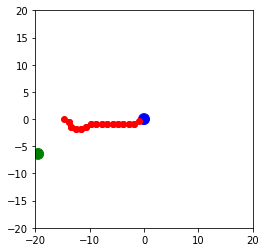

 54%|███████████████████████████████████████▉                                  | 269996/500000 [53:03<43:49, 87.46it/s]

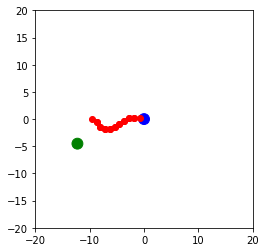

 54%|████████████████████████████████████████                                  | 270992/500000 [53:15<44:33, 85.65it/s]

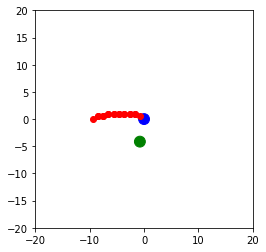

 54%|████████████████████████████████████████▎                                 | 271993/500000 [53:27<44:11, 86.01it/s]

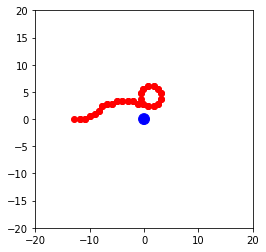

 55%|████████████████████████████████████████▍                                 | 272994/500000 [53:39<44:08, 85.70it/s]

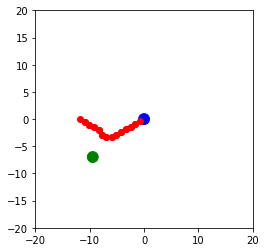

 55%|████████████████████████████████████████▌                                 | 273997/500000 [53:50<41:54, 89.88it/s]

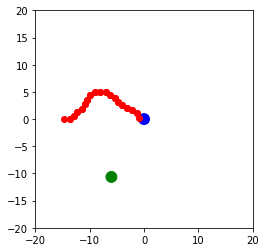

 55%|████████████████████████████████████████▋                                 | 274998/500000 [54:02<44:00, 85.20it/s]

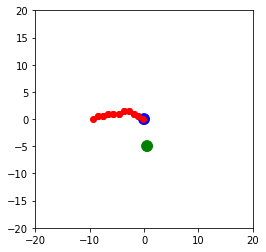

 55%|████████████████████████████████████████▊                                 | 275999/500000 [54:13<42:24, 88.02it/s]

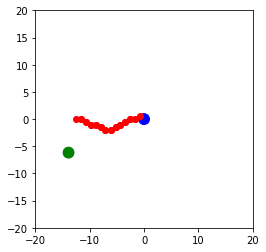

 55%|████████████████████████████████████████▉                                 | 276998/500000 [54:25<41:45, 89.00it/s]

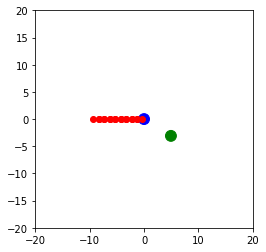

 56%|█████████████████████████████████████████▏                                | 277996/500000 [54:36<43:09, 85.73it/s]

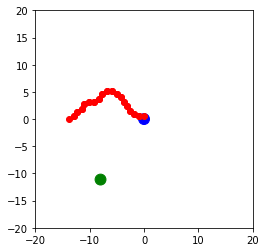

 56%|█████████████████████████████████████████▎                                | 279000/500000 [54:48<45:30, 80.94it/s]

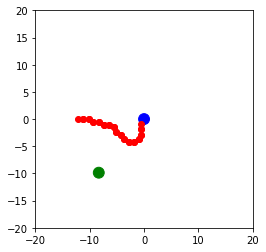

 56%|█████████████████████████████████████████▍                                | 279994/500000 [55:00<39:55, 91.82it/s]

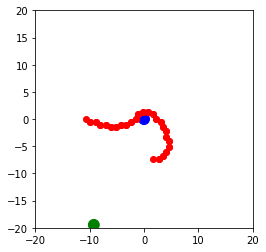

 56%|█████████████████████████████████████████▌                                | 281000/500000 [55:11<50:01, 72.97it/s]

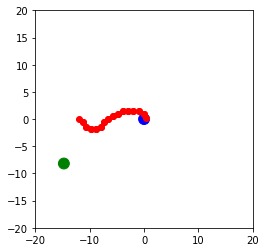

 56%|█████████████████████████████████████████▋                                | 281994/500000 [55:23<40:26, 89.84it/s]

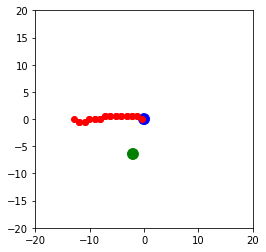

 57%|█████████████████████████████████████████▉                                | 282994/500000 [55:34<40:46, 88.71it/s]

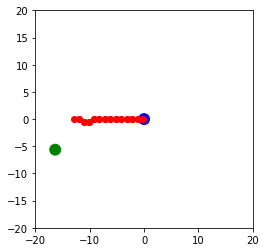

 57%|██████████████████████████████████████████                                | 283994/500000 [55:45<40:22, 89.17it/s]

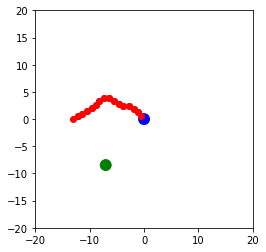

 57%|██████████████████████████████████████████▏                               | 284994/500000 [55:57<41:41, 85.94it/s]

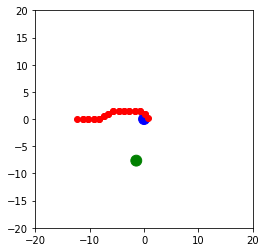

 57%|██████████████████████████████████████████▎                               | 285994/500000 [56:08<40:23, 88.32it/s]

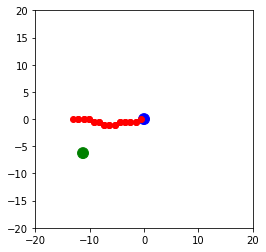

 57%|██████████████████████████████████████████▍                               | 287000/500000 [56:20<40:34, 87.49it/s]

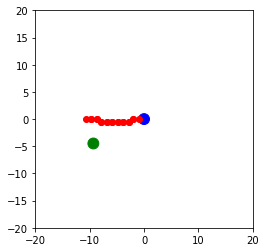

 58%|██████████████████████████████████████████▌                               | 287994/500000 [56:32<36:45, 96.13it/s]

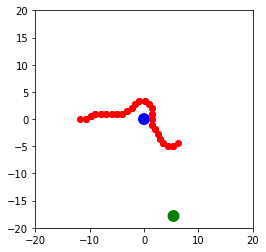

 58%|██████████████████████████████████████████▊                               | 288992/500000 [56:43<41:41, 84.34it/s]

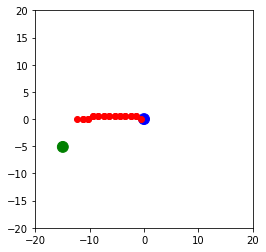

 58%|██████████████████████████████████████████▉                               | 290000/500000 [56:55<37:27, 93.44it/s]

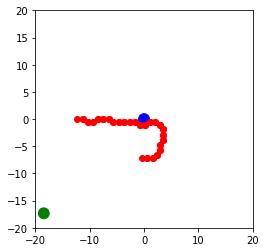

 58%|███████████████████████████████████████████                               | 290991/500000 [57:06<39:38, 87.89it/s]

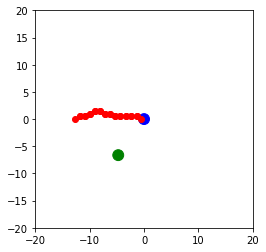

 58%|███████████████████████████████████████████▏                              | 292000/500000 [57:18<39:39, 87.41it/s]

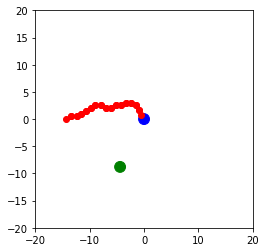

 59%|███████████████████████████████████████████▎                              | 292994/500000 [57:29<39:20, 87.71it/s]

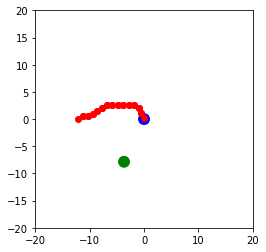

 59%|███████████████████████████████████████████▌                              | 294000/500000 [57:41<38:36, 88.94it/s]

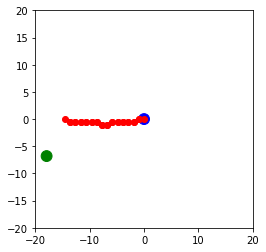

 59%|███████████████████████████████████████████▋                              | 294996/500000 [57:53<38:24, 88.97it/s]

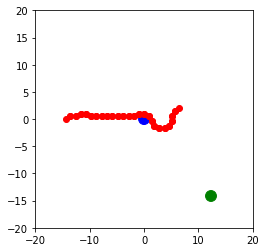

 59%|███████████████████████████████████████████▊                              | 295992/500000 [58:04<37:49, 89.88it/s]

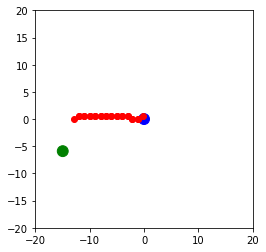

 59%|███████████████████████████████████████████▉                              | 296992/500000 [58:16<40:16, 84.00it/s]

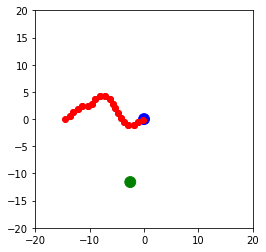

 60%|████████████████████████████████████████████                              | 298000/500000 [58:27<40:23, 83.35it/s]

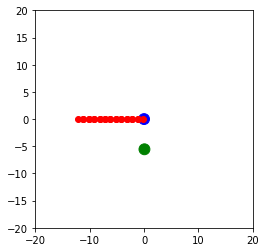

 60%|████████████████████████████████████████████▎                             | 298991/500000 [58:39<37:02, 90.46it/s]

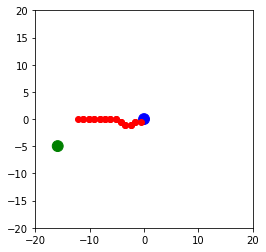

 60%|████████████████████████████████████████████▍                             | 299996/500000 [58:51<41:17, 80.73it/s]

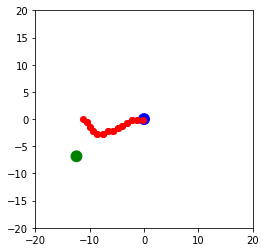

 60%|████████████████████████████████████████████▌                             | 301000/500000 [59:03<38:10, 86.88it/s]

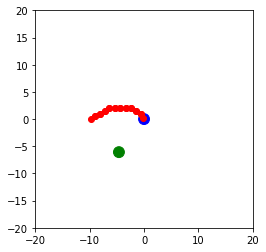

 60%|████████████████████████████████████████████▋                             | 301999/500000 [59:14<40:10, 82.15it/s]

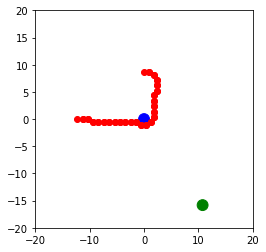

 61%|████████████████████████████████████████████▊                             | 302999/500000 [59:26<38:34, 85.13it/s]

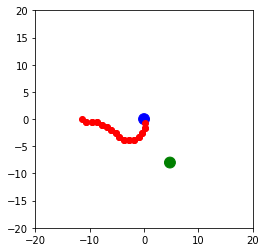

 61%|████████████████████████████████████████████▉                             | 303994/500000 [59:38<35:46, 91.30it/s]

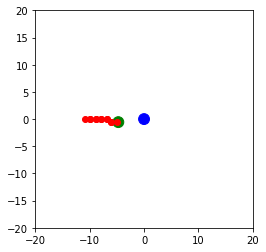

 61%|█████████████████████████████████████████████▏                            | 304991/500000 [59:49<35:14, 92.24it/s]

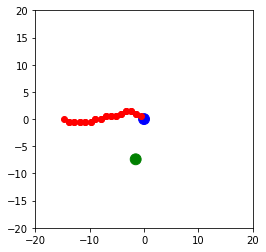

 61%|████████████████████████████████████████████                            | 305997/500000 [1:00:00<34:52, 92.71it/s]

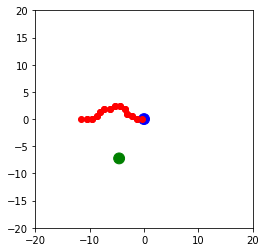

 61%|████████████████████████████████████████████▏                           | 306998/500000 [1:00:12<36:32, 88.05it/s]

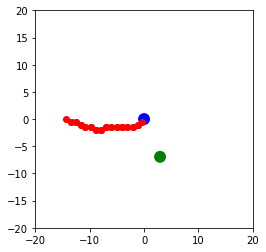

 62%|████████████████████████████████████████████▎                           | 307993/500000 [1:00:23<34:12, 93.57it/s]

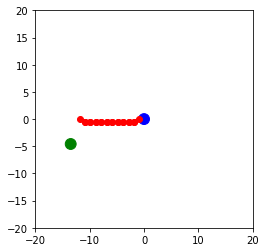

 62%|████████████████████████████████████████████▍                           | 308998/500000 [1:00:34<34:45, 91.57it/s]

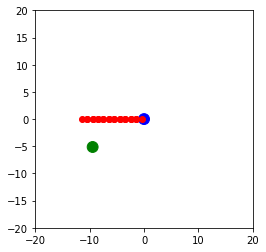

 62%|████████████████████████████████████████████▋                           | 310000/500000 [1:00:46<38:19, 82.62it/s]

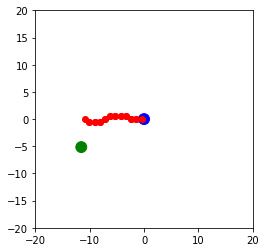

 62%|████████████████████████████████████████████▊                           | 310993/500000 [1:00:58<37:33, 83.86it/s]

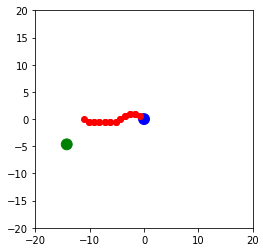

 62%|████████████████████████████████████████████▉                           | 311994/500000 [1:01:09<37:31, 83.51it/s]

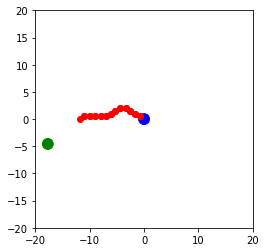

 63%|█████████████████████████████████████████████                           | 312996/500000 [1:01:21<35:43, 87.22it/s]

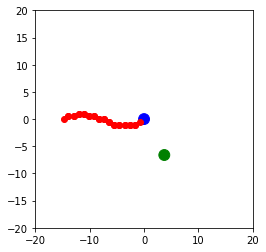

 63%|█████████████████████████████████████████████▏                          | 313998/500000 [1:01:33<39:00, 79.48it/s]

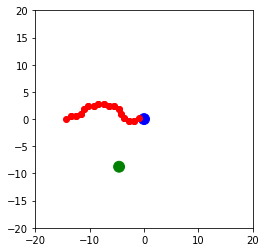

 63%|█████████████████████████████████████████████▎                          | 314995/500000 [1:01:45<33:01, 93.34it/s]

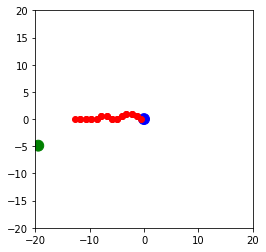

 63%|█████████████████████████████████████████████▌                          | 315993/500000 [1:01:56<32:16, 95.01it/s]

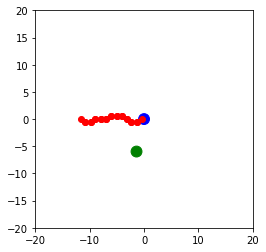

 63%|█████████████████████████████████████████████▋                          | 316997/500000 [1:02:08<33:47, 90.25it/s]

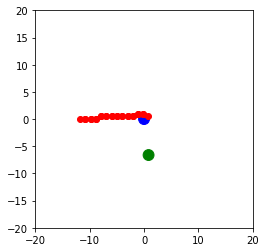

 64%|█████████████████████████████████████████████▊                          | 317993/500000 [1:02:19<34:39, 87.54it/s]

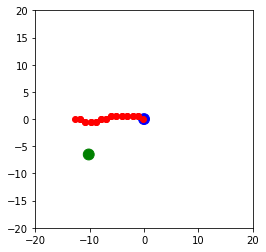

 64%|█████████████████████████████████████████████▉                          | 318994/500000 [1:02:30<30:48, 97.93it/s]

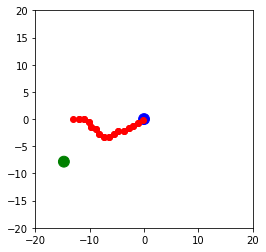

 64%|██████████████████████████████████████████████                          | 319993/500000 [1:02:42<36:30, 82.19it/s]

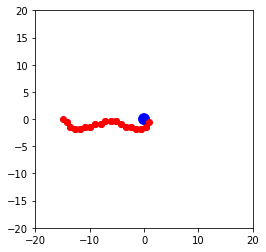

 64%|██████████████████████████████████████████████▏                         | 320997/500000 [1:02:53<30:47, 96.90it/s]

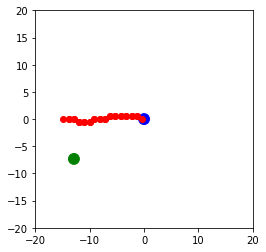

 64%|██████████████████████████████████████████████▎                         | 321997/500000 [1:03:05<32:11, 92.14it/s]

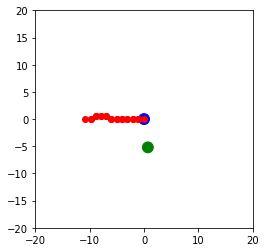

 65%|██████████████████████████████████████████████▌                         | 322999/500000 [1:03:16<32:17, 91.34it/s]

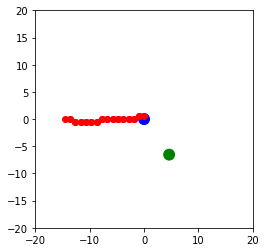

 65%|██████████████████████████████████████████████▋                         | 323992/500000 [1:03:28<31:57, 91.81it/s]

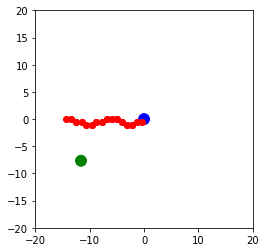

 65%|██████████████████████████████████████████████▊                         | 324998/500000 [1:03:39<34:37, 84.22it/s]

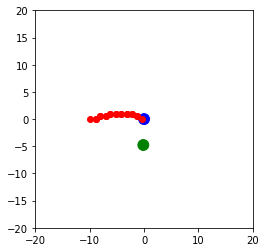

 65%|██████████████████████████████████████████████▉                         | 325998/500000 [1:03:51<36:34, 79.28it/s]

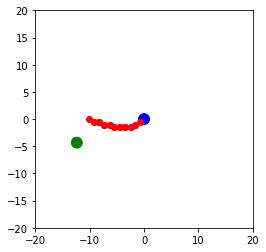

 65%|███████████████████████████████████████████████                         | 326993/500000 [1:04:02<33:22, 86.41it/s]

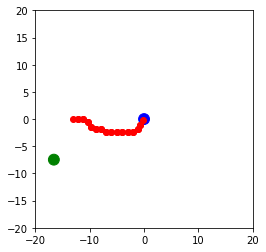

 66%|███████████████████████████████████████████████▏                        | 327993/500000 [1:04:14<32:56, 87.05it/s]

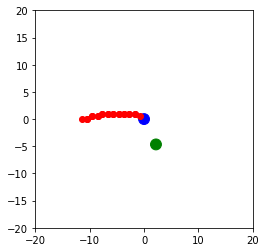

 66%|███████████████████████████████████████████████▍                        | 328996/500000 [1:04:25<30:24, 93.73it/s]

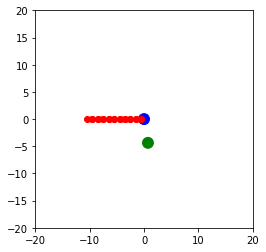

 66%|███████████████████████████████████████████████▌                        | 330000/500000 [1:04:37<33:36, 84.32it/s]

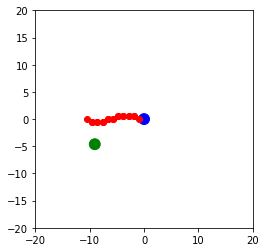

 66%|███████████████████████████████████████████████▋                        | 330998/500000 [1:04:48<32:39, 86.26it/s]

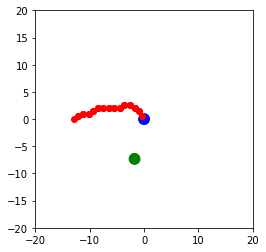

 66%|███████████████████████████████████████████████▊                        | 331990/500000 [1:05:00<30:08, 92.92it/s]

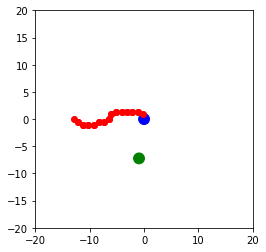

 67%|███████████████████████████████████████████████▉                        | 332993/500000 [1:05:11<28:13, 98.61it/s]

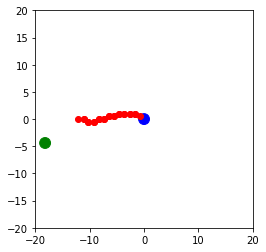

 67%|████████████████████████████████████████████████                        | 333995/500000 [1:05:23<32:11, 85.93it/s]

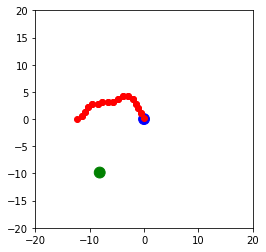

 67%|████████████████████████████████████████████████▏                       | 334994/500000 [1:05:34<29:43, 92.51it/s]

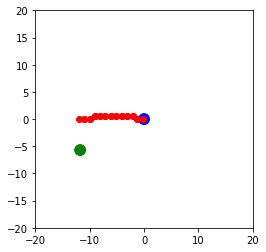

 67%|████████████████████████████████████████████████▍                       | 335998/500000 [1:05:46<32:09, 85.00it/s]

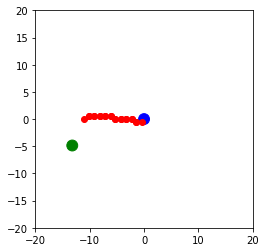

 67%|████████████████████████████████████████████████▌                       | 336996/500000 [1:05:58<31:00, 87.60it/s]

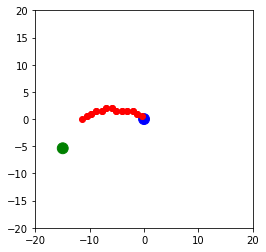

 68%|████████████████████████████████████████████████▋                       | 337995/500000 [1:06:09<29:01, 93.05it/s]

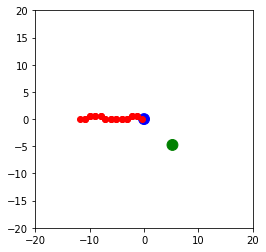

 68%|████████████████████████████████████████████████▊                       | 338999/500000 [1:06:21<28:58, 92.64it/s]

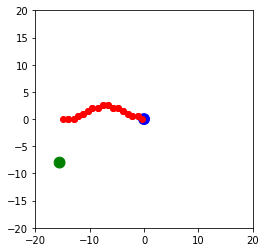

 68%|████████████████████████████████████████████████▉                       | 339997/500000 [1:06:32<30:45, 86.68it/s]

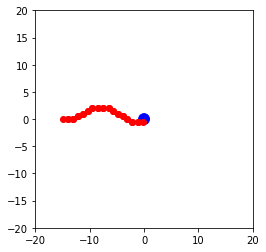

 68%|█████████████████████████████████████████████████                       | 340993/500000 [1:06:43<31:33, 83.98it/s]

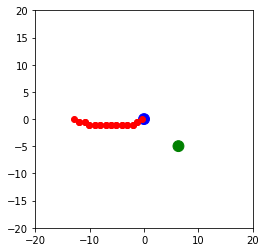

 68%|█████████████████████████████████████████████████▏                      | 341994/500000 [1:06:55<31:38, 83.24it/s]

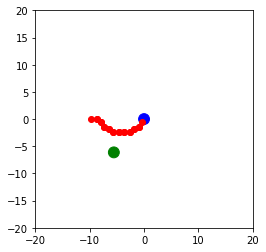

 69%|█████████████████████████████████████████████████▍                      | 343000/500000 [1:07:07<31:45, 82.40it/s]

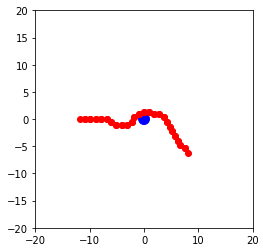

 69%|█████████████████████████████████████████████████▌                      | 343995/500000 [1:07:19<28:09, 92.32it/s]

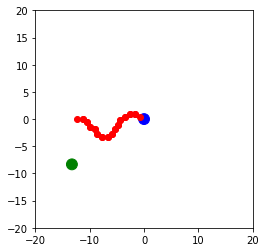

 69%|█████████████████████████████████████████████████▋                      | 344997/500000 [1:07:30<29:36, 87.27it/s]

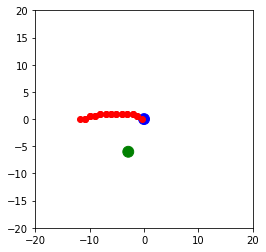

 69%|█████████████████████████████████████████████████▊                      | 345994/500000 [1:07:42<30:02, 85.44it/s]

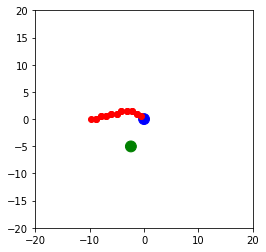

 69%|█████████████████████████████████████████████████▉                      | 346997/500000 [1:07:53<29:00, 87.90it/s]

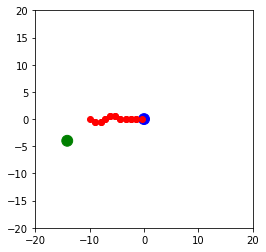

 70%|██████████████████████████████████████████████████                      | 347997/500000 [1:08:04<29:24, 86.15it/s]

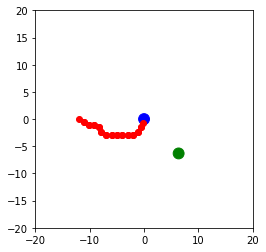

 70%|██████████████████████████████████████████████████▎                     | 348993/500000 [1:08:16<28:22, 88.68it/s]

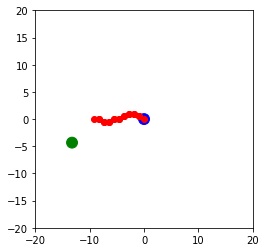

 70%|██████████████████████████████████████████████████▍                     | 349999/500000 [1:08:27<27:35, 90.60it/s]

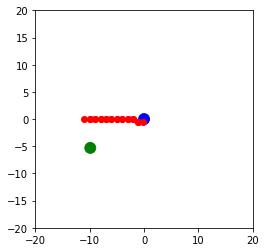

 70%|██████████████████████████████████████████████████▌                     | 350995/500000 [1:08:39<29:48, 83.29it/s]

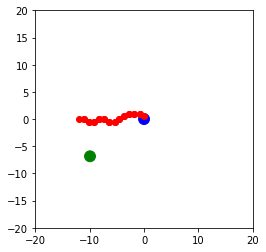

 70%|██████████████████████████████████████████████████▋                     | 351992/500000 [1:08:50<29:14, 84.36it/s]

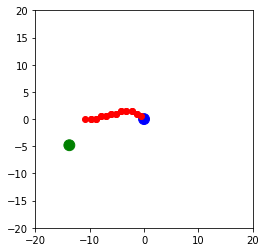

 71%|██████████████████████████████████████████████████▊                     | 352994/500000 [1:09:02<27:35, 88.78it/s]

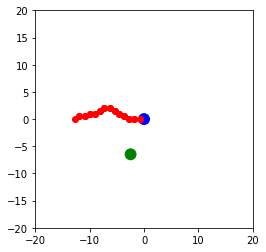

 71%|██████████████████████████████████████████████████▉                     | 353992/500000 [1:09:13<26:35, 91.49it/s]

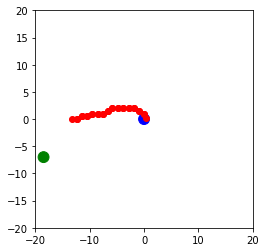

 71%|███████████████████████████████████████████████████                     | 354997/500000 [1:09:25<29:39, 81.50it/s]

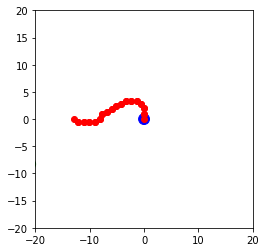

 71%|███████████████████████████████████████████████████▎                    | 355996/500000 [1:09:36<28:15, 84.94it/s]

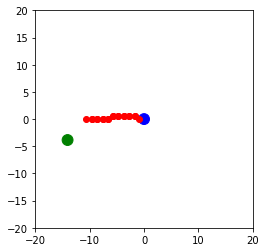

 71%|███████████████████████████████████████████████████▍                    | 356994/500000 [1:09:48<27:36, 86.36it/s]

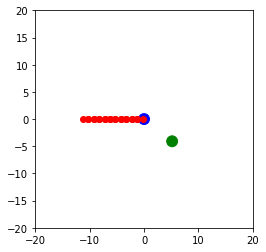

 72%|███████████████████████████████████████████████████▌                    | 357997/500000 [1:09:59<30:10, 78.44it/s]

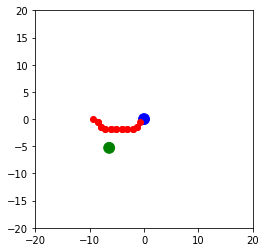

 72%|███████████████████████████████████████████████████▋                    | 358998/500000 [1:10:11<28:37, 82.11it/s]

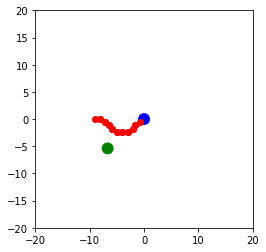

 72%|███████████████████████████████████████████████████▊                    | 359999/500000 [1:10:23<25:25, 91.79it/s]

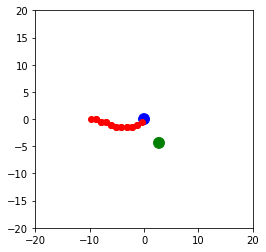

 72%|███████████████████████████████████████████████████▉                    | 360999/500000 [1:10:35<26:23, 87.77it/s]

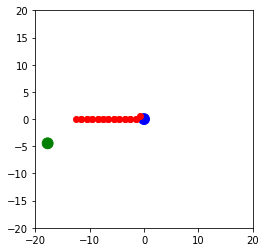

 72%|████████████████████████████████████████████████████▏                   | 361999/500000 [1:10:46<26:03, 88.25it/s]

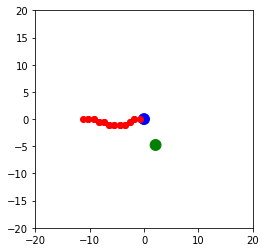

 73%|████████████████████████████████████████████████████▎                   | 362991/500000 [1:10:58<26:01, 87.76it/s]

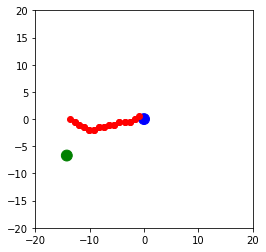

 73%|████████████████████████████████████████████████████▍                   | 363991/500000 [1:11:09<25:09, 90.07it/s]

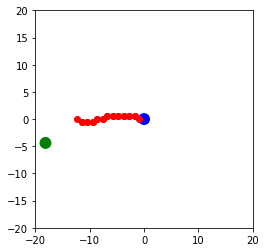

 73%|████████████████████████████████████████████████████▌                   | 364996/500000 [1:11:21<27:33, 81.64it/s]

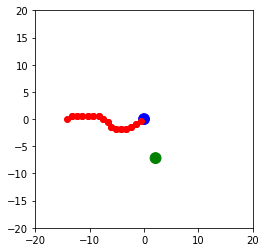

 73%|████████████████████████████████████████████████████▋                   | 365998/500000 [1:11:32<25:01, 89.23it/s]

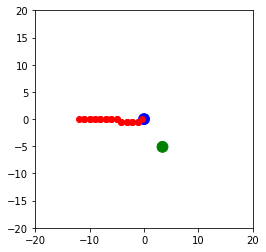

 73%|████████████████████████████████████████████████████▊                   | 366991/500000 [1:11:43<24:11, 91.64it/s]

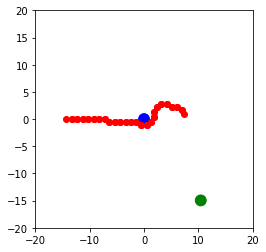

 74%|████████████████████████████████████████████████████▉                   | 367993/500000 [1:11:55<24:32, 89.67it/s]

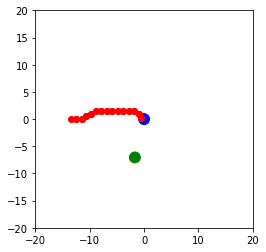

 74%|█████████████████████████████████████████████████████▏                  | 368997/500000 [1:12:06<23:38, 92.37it/s]

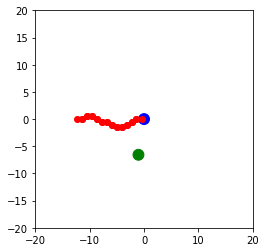

 74%|█████████████████████████████████████████████████████▎                  | 369999/500000 [1:12:18<24:06, 89.89it/s]

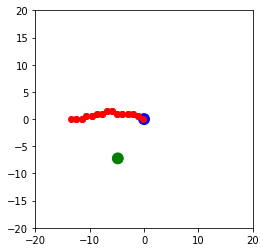

 74%|█████████████████████████████████████████████████████▍                  | 370998/500000 [1:12:30<24:54, 86.35it/s]

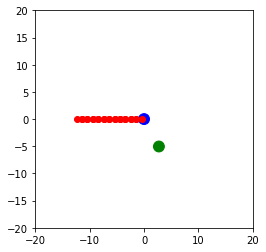

 74%|█████████████████████████████████████████████████████▌                  | 371996/500000 [1:12:41<24:58, 85.40it/s]

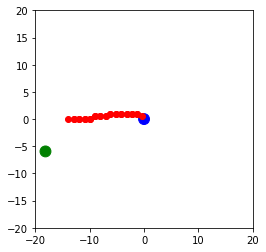

 75%|█████████████████████████████████████████████████████▋                  | 372999/500000 [1:12:53<22:44, 93.04it/s]

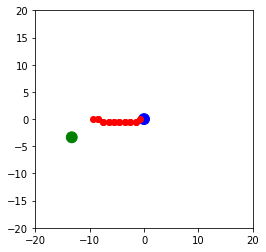

 75%|█████████████████████████████████████████████████████▊                  | 374000/500000 [1:13:05<23:52, 87.93it/s]

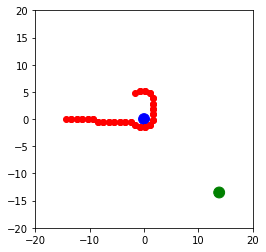

 75%|█████████████████████████████████████████████████████▉                  | 374995/500000 [1:13:16<23:01, 90.51it/s]

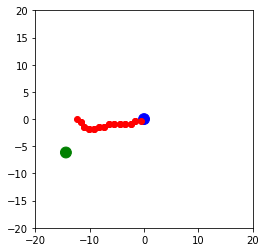

 75%|██████████████████████████████████████████████████████▏                 | 375998/500000 [1:13:27<22:47, 90.70it/s]

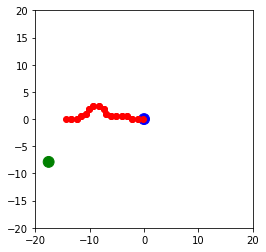

 75%|██████████████████████████████████████████████████████▎                 | 376997/500000 [1:13:39<23:50, 85.96it/s]

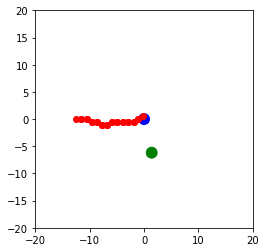

 76%|██████████████████████████████████████████████████████▍                 | 377997/500000 [1:13:51<21:47, 93.31it/s]

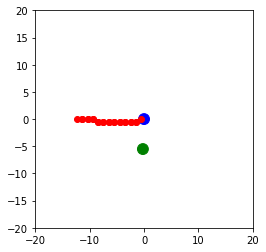

 76%|██████████████████████████████████████████████████████▌                 | 378999/500000 [1:14:02<21:01, 95.89it/s]

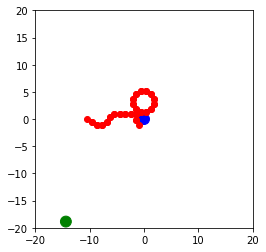

 76%|██████████████████████████████████████████████████████▋                 | 379994/500000 [1:14:13<22:25, 89.18it/s]

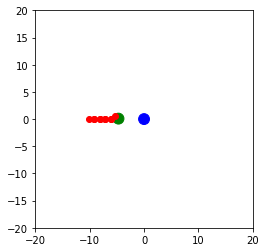

 76%|██████████████████████████████████████████████████████▊                 | 380992/500000 [1:14:24<24:18, 81.59it/s]

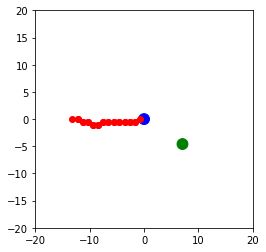

 76%|███████████████████████████████████████████████████████                 | 382000/500000 [1:14:35<20:39, 95.17it/s]

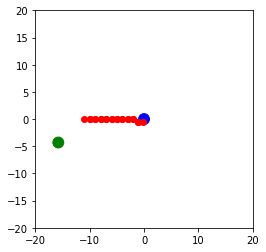

 77%|███████████████████████████████████████████████████████▏                | 382991/500000 [1:14:46<21:15, 91.74it/s]

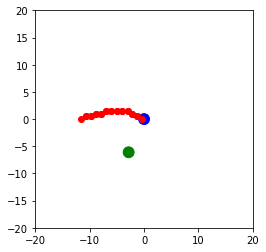

 77%|███████████████████████████████████████████████████████▎                | 383994/500000 [1:14:57<20:10, 95.86it/s]

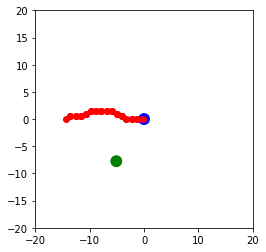

 77%|███████████████████████████████████████████████████████▍                | 384997/500000 [1:15:09<21:19, 89.88it/s]

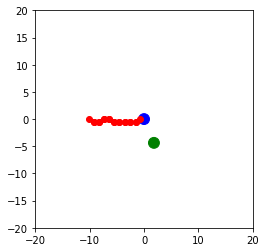

 77%|███████████████████████████████████████████████████████▌                | 386000/500000 [1:15:20<21:36, 87.91it/s]

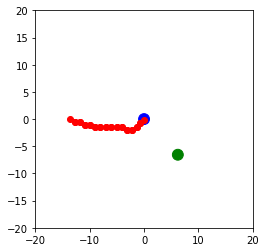

 77%|███████████████████████████████████████████████████████▋                | 386996/500000 [1:15:31<21:22, 88.12it/s]

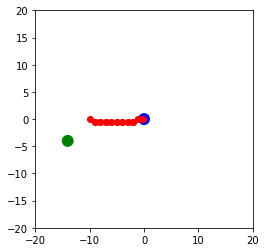

 78%|███████████████████████████████████████████████████████▊                | 387999/500000 [1:15:42<19:30, 95.69it/s]

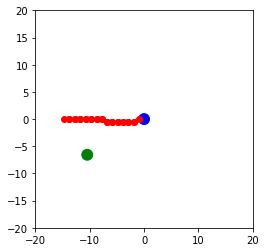

 78%|████████████████████████████████████████████████████████                | 388994/500000 [1:15:54<22:54, 80.75it/s]

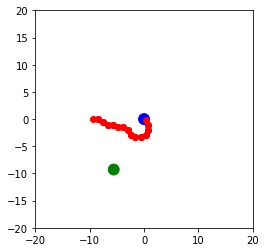

 78%|████████████████████████████████████████████████████████▏               | 389991/500000 [1:16:06<21:00, 87.25it/s]

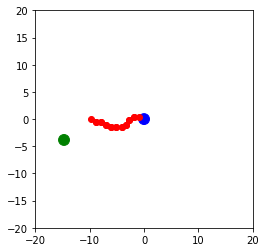

 78%|████████████████████████████████████████████████████████▎               | 390995/500000 [1:16:17<20:43, 87.64it/s]

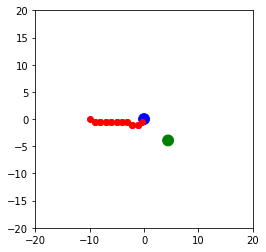

 78%|████████████████████████████████████████████████████████▍               | 391998/500000 [1:16:28<19:15, 93.44it/s]

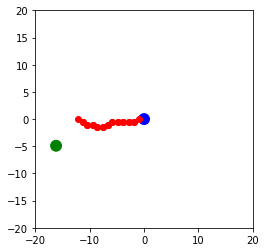

 79%|████████████████████████████████████████████████████████▌               | 392993/500000 [1:16:40<21:00, 84.89it/s]

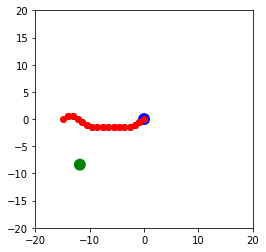

 79%|████████████████████████████████████████████████████████▋               | 394000/500000 [1:16:51<19:12, 91.94it/s]

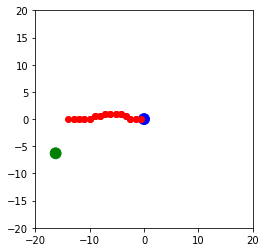

 79%|████████████████████████████████████████████████████████▉               | 394991/500000 [1:17:02<19:41, 88.88it/s]

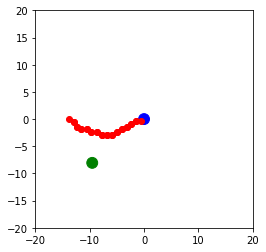

 79%|█████████████████████████████████████████████████████████               | 395992/500000 [1:17:13<19:14, 90.05it/s]

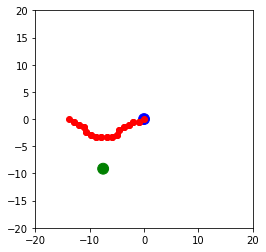

 79%|█████████████████████████████████████████████████████████▏              | 396994/500000 [1:17:24<17:59, 95.38it/s]

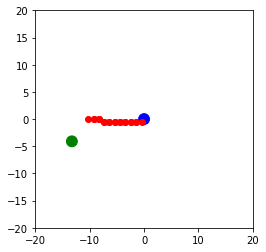

 80%|█████████████████████████████████████████████████████████▎              | 397993/500000 [1:17:35<19:16, 88.18it/s]

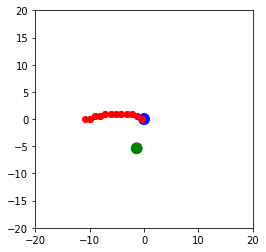

 80%|█████████████████████████████████████████████████████████▍              | 399000/500000 [1:17:47<17:59, 93.53it/s]

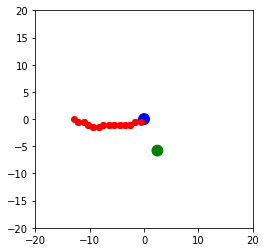

 80%|█████████████████████████████████████████████████████████▌              | 400000/500000 [1:17:58<19:30, 85.43it/s]

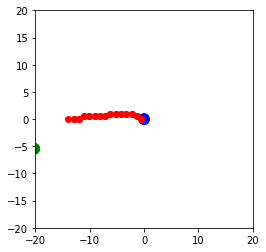

 80%|█████████████████████████████████████████████████████████▋              | 401000/500000 [1:18:09<18:42, 88.21it/s]

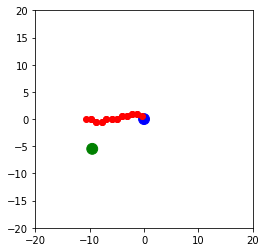

 80%|█████████████████████████████████████████████████████████▉              | 401995/500000 [1:18:21<18:14, 89.55it/s]

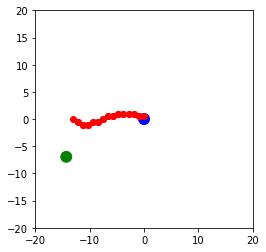

 81%|██████████████████████████████████████████████████████████              | 402993/500000 [1:18:32<19:40, 82.18it/s]

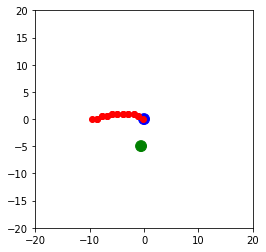

 81%|██████████████████████████████████████████████████████████▏             | 403994/500000 [1:18:44<18:54, 84.59it/s]

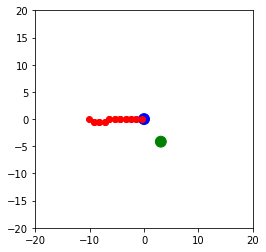

 81%|██████████████████████████████████████████████████████████▎             | 404993/500000 [1:18:55<17:18, 91.52it/s]

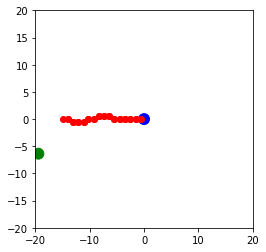

 81%|██████████████████████████████████████████████████████████▍             | 405993/500000 [1:19:06<16:16, 96.27it/s]

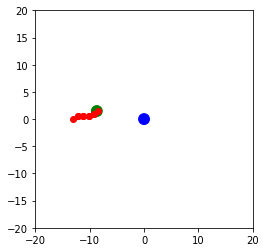

 81%|██████████████████████████████████████████████████████████▌             | 406999/500000 [1:19:17<18:32, 83.58it/s]

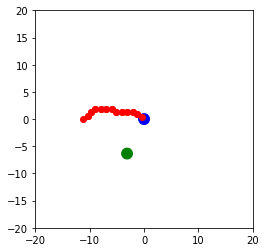

 82%|██████████████████████████████████████████████████████████▊             | 407995/500000 [1:19:29<16:46, 91.41it/s]

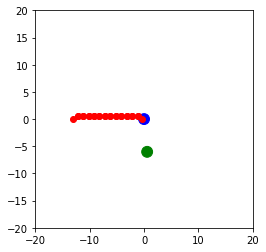

 82%|██████████████████████████████████████████████████████████▉             | 408997/500000 [1:19:40<16:26, 92.25it/s]

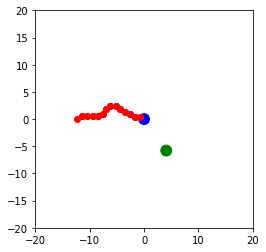

 82%|███████████████████████████████████████████████████████████             | 409992/500000 [1:19:51<16:10, 92.78it/s]

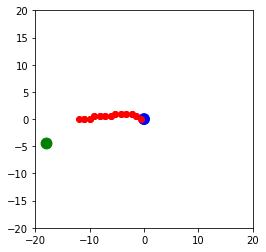

 82%|███████████████████████████████████████████████████████████▏            | 410991/500000 [1:20:02<16:22, 90.56it/s]

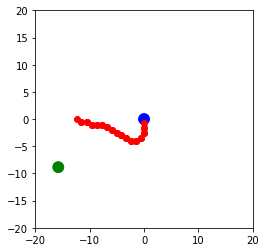

 82%|███████████████████████████████████████████████████████████▎            | 411994/500000 [1:20:14<15:53, 92.26it/s]

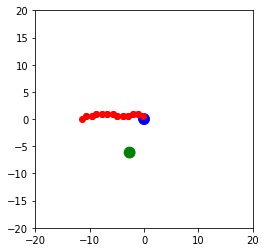

 83%|███████████████████████████████████████████████████████████▍            | 412988/500000 [1:20:25<17:13, 84.17it/s]

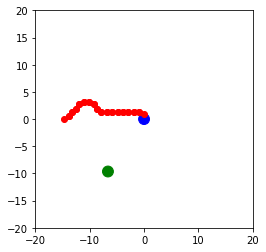

 83%|███████████████████████████████████████████████████████████▌            | 413996/500000 [1:20:36<16:08, 88.82it/s]

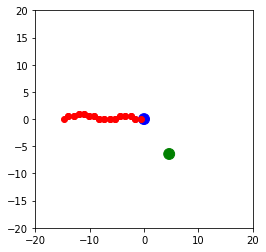

 83%|███████████████████████████████████████████████████████████▊            | 414997/500000 [1:20:48<16:56, 83.62it/s]

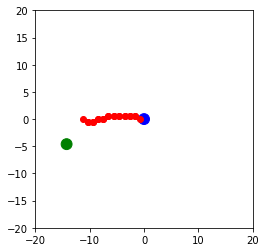

 83%|███████████████████████████████████████████████████████████▉            | 415994/500000 [1:21:00<16:13, 86.33it/s]

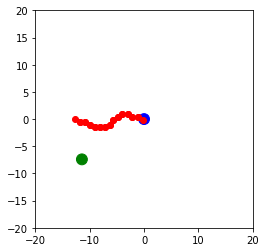

 83%|████████████████████████████████████████████████████████████            | 416991/500000 [1:21:11<15:34, 88.85it/s]

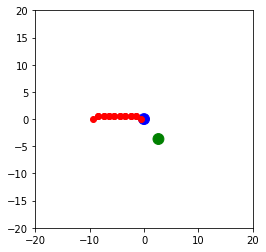

 84%|████████████████████████████████████████████████████████████▏           | 417999/500000 [1:21:23<16:28, 82.95it/s]

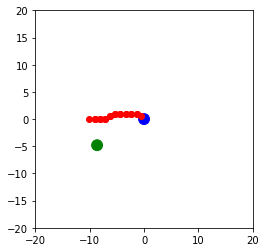

 84%|████████████████████████████████████████████████████████████▎           | 418995/500000 [1:21:35<14:25, 93.65it/s]

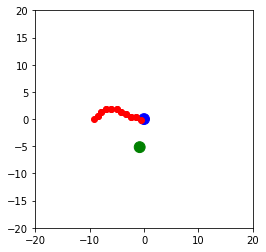

 84%|████████████████████████████████████████████████████████████▍           | 420000/500000 [1:21:46<15:16, 87.28it/s]

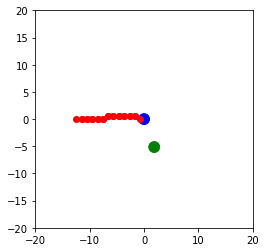

 84%|████████████████████████████████████████████████████████████▌           | 421000/500000 [1:21:58<15:55, 82.71it/s]

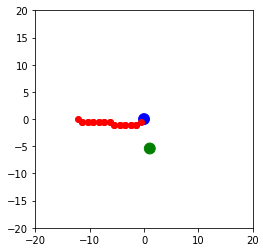

 84%|████████████████████████████████████████████████████████████▊           | 421998/500000 [1:22:09<15:33, 83.52it/s]

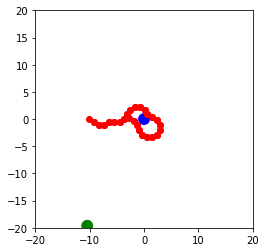

 85%|████████████████████████████████████████████████████████████▉           | 422994/500000 [1:22:21<15:16, 84.00it/s]

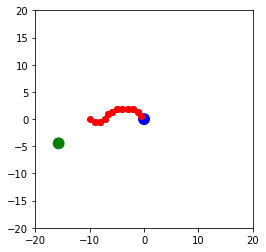

 85%|█████████████████████████████████████████████████████████████           | 423992/500000 [1:22:32<14:25, 87.86it/s]

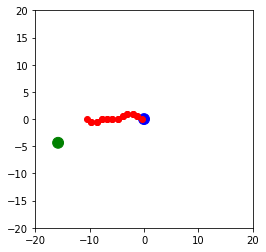

 85%|█████████████████████████████████████████████████████████████▏          | 424997/500000 [1:22:44<14:28, 86.40it/s]

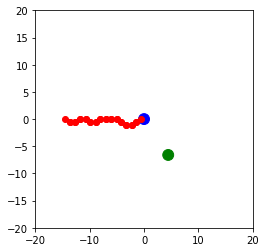

 85%|█████████████████████████████████████████████████████████████▎          | 425996/500000 [1:22:55<13:13, 93.30it/s]

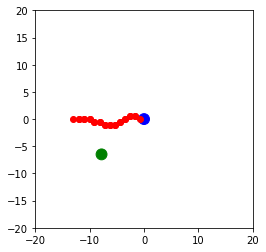

 85%|█████████████████████████████████████████████████████████████▍          | 426993/500000 [1:23:06<13:13, 92.05it/s]

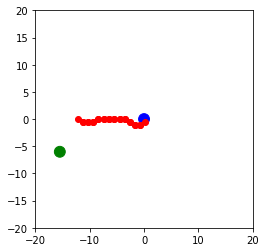

 86%|█████████████████████████████████████████████████████████████▋          | 427998/500000 [1:23:17<15:29, 77.49it/s]

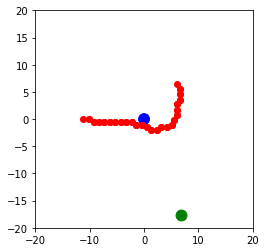

 86%|█████████████████████████████████████████████████████████████▊          | 428996/500000 [1:23:29<13:21, 88.57it/s]

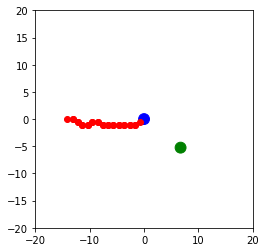

 86%|█████████████████████████████████████████████████████████████▉          | 429997/500000 [1:23:40<13:47, 84.59it/s]

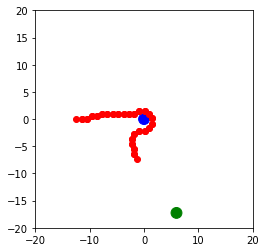

 86%|██████████████████████████████████████████████████████████████          | 430993/500000 [1:23:52<12:48, 89.80it/s]

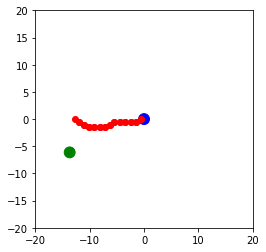

 86%|██████████████████████████████████████████████████████████████▏         | 431999/500000 [1:24:03<13:22, 84.71it/s]

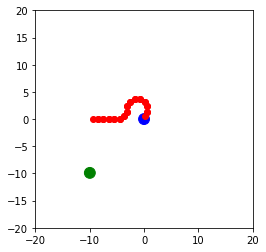

 87%|██████████████████████████████████████████████████████████████▎         | 432996/500000 [1:24:14<12:35, 88.70it/s]

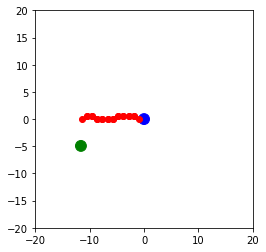

 87%|██████████████████████████████████████████████████████████████▍         | 433998/500000 [1:24:26<12:56, 84.99it/s]

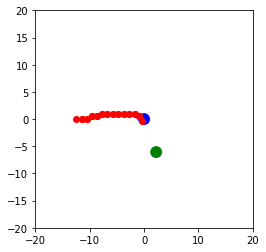

 87%|██████████████████████████████████████████████████████████████▋         | 434996/500000 [1:24:37<12:05, 89.59it/s]

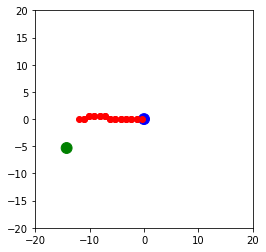

 87%|██████████████████████████████████████████████████████████████▊         | 435991/500000 [1:24:48<10:59, 96.99it/s]

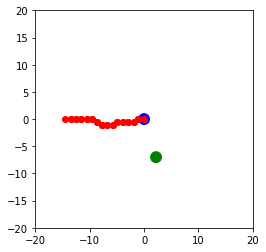

 87%|██████████████████████████████████████████████████████████████▉         | 436998/500000 [1:24:59<11:31, 91.08it/s]

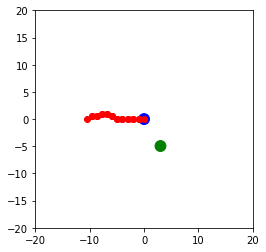

 88%|███████████████████████████████████████████████████████████████         | 437994/500000 [1:25:10<10:35, 97.52it/s]

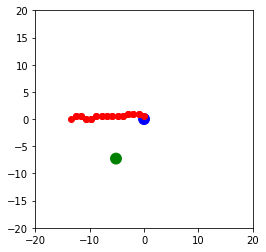

 88%|███████████████████████████████████████████████████████████████▏        | 438994/500000 [1:25:21<10:41, 95.04it/s]

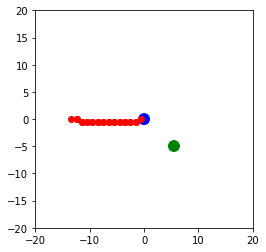

 88%|███████████████████████████████████████████████████████████████▎        | 439996/500000 [1:25:33<11:08, 89.70it/s]

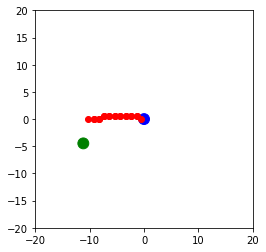

 88%|███████████████████████████████████████████████████████████████▌        | 440990/500000 [1:25:44<11:28, 85.74it/s]

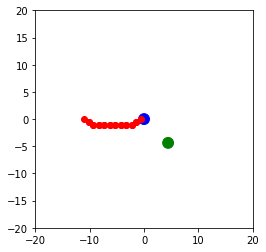

 88%|███████████████████████████████████████████████████████████████▋        | 441991/500000 [1:25:55<10:27, 92.49it/s]

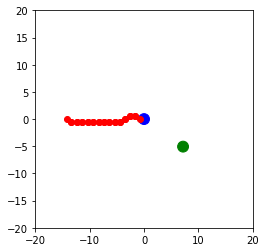

 89%|███████████████████████████████████████████████████████████████▊        | 442990/500000 [1:26:06<10:31, 90.29it/s]

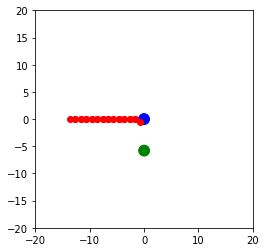

 89%|███████████████████████████████████████████████████████████████▉        | 443999/500000 [1:26:18<09:50, 94.76it/s]

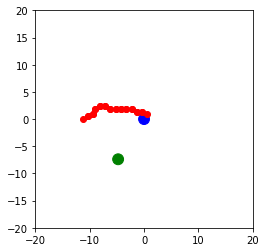

 89%|████████████████████████████████████████████████████████████████        | 444994/500000 [1:26:29<10:17, 89.11it/s]

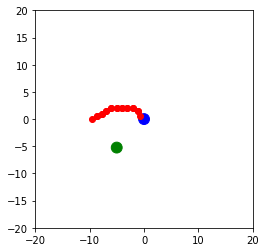

 89%|████████████████████████████████████████████████████████████████▏       | 445998/500000 [1:26:40<10:14, 87.83it/s]

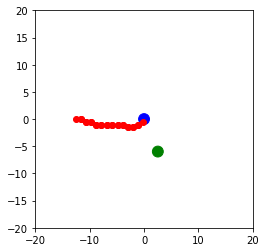

 89%|████████████████████████████████████████████████████████████████▎       | 446998/500000 [1:26:51<10:04, 87.70it/s]

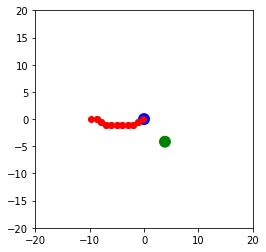

 90%|████████████████████████████████████████████████████████████████▌       | 447997/500000 [1:27:02<09:26, 91.88it/s]

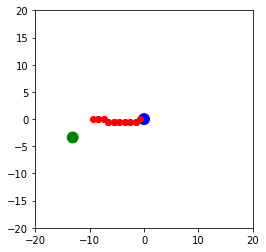

 90%|████████████████████████████████████████████████████████████████▋       | 448992/500000 [1:27:13<09:51, 86.26it/s]

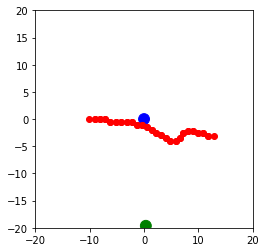

 90%|████████████████████████████████████████████████████████████████▊       | 449998/500000 [1:27:25<08:34, 97.24it/s]

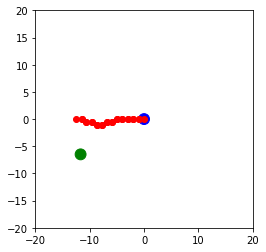

 90%|████████████████████████████████████████████████████████████████▉       | 450995/500000 [1:27:36<08:58, 91.01it/s]

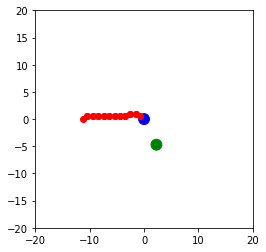

 90%|█████████████████████████████████████████████████████████████████       | 452000/500000 [1:27:47<08:44, 91.44it/s]

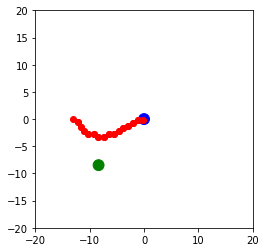

 91%|█████████████████████████████████████████████████████████████████▏      | 453000/500000 [1:27:58<08:29, 92.27it/s]

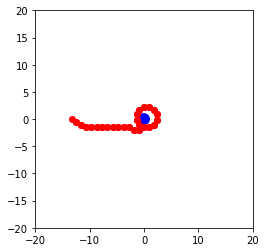

 91%|█████████████████████████████████████████████████████████████████▍      | 454000/500000 [1:28:10<08:57, 85.59it/s]

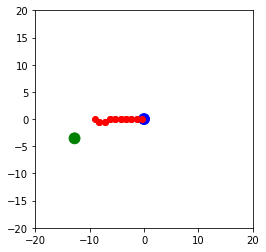

 91%|█████████████████████████████████████████████████████████████████▌      | 454995/500000 [1:28:21<08:23, 89.41it/s]

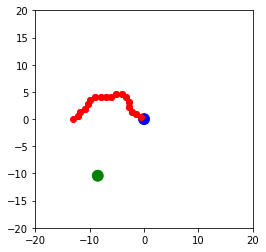

 91%|█████████████████████████████████████████████████████████████████▋      | 455992/500000 [1:28:32<08:14, 88.95it/s]

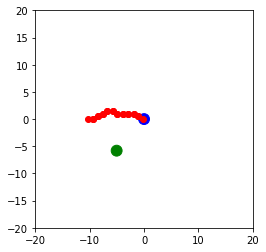

 91%|█████████████████████████████████████████████████████████████████▊      | 456999/500000 [1:28:44<07:58, 89.89it/s]

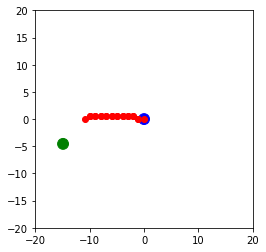

 92%|█████████████████████████████████████████████████████████████████▉      | 457992/500000 [1:28:55<08:23, 83.36it/s]

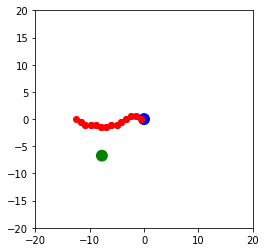

 92%|██████████████████████████████████████████████████████████████████      | 458995/500000 [1:29:06<07:32, 90.71it/s]

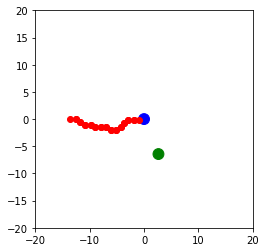

 92%|██████████████████████████████████████████████████████████████████▏     | 459994/500000 [1:29:17<07:49, 85.13it/s]

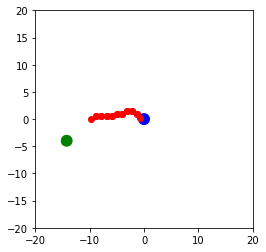

 92%|██████████████████████████████████████████████████████████████████▍     | 460999/500000 [1:29:29<07:06, 91.50it/s]

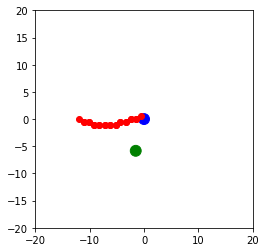

 92%|██████████████████████████████████████████████████████████████████▌     | 461991/500000 [1:29:40<06:59, 90.63it/s]

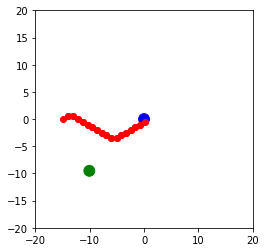

 93%|██████████████████████████████████████████████████████████████████▋     | 462999/500000 [1:29:51<06:46, 90.93it/s]

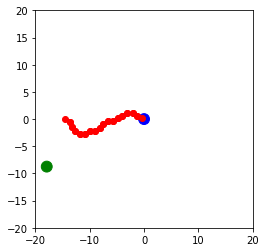

 93%|██████████████████████████████████████████████████████████████████▊     | 463997/500000 [1:30:02<06:33, 91.53it/s]

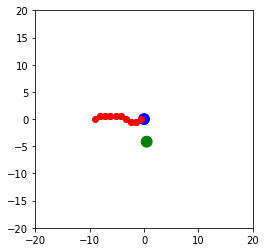

 93%|██████████████████████████████████████████████████████████████████▉     | 464997/500000 [1:30:13<06:47, 85.97it/s]

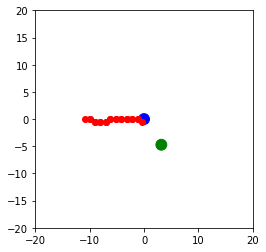

 93%|███████████████████████████████████████████████████████████████████     | 466000/500000 [1:30:25<06:22, 88.79it/s]

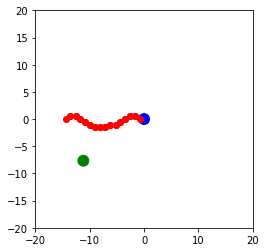

 93%|███████████████████████████████████████████████████████████████████▏    | 466998/500000 [1:30:36<06:00, 91.55it/s]

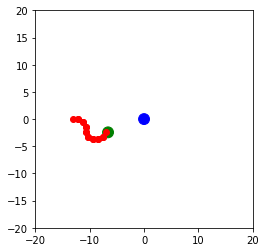

 94%|███████████████████████████████████████████████████████████████████▍    | 467993/500000 [1:30:47<06:16, 84.97it/s]

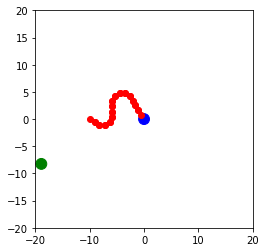

 94%|███████████████████████████████████████████████████████████████████▌    | 468996/500000 [1:30:59<06:17, 82.09it/s]

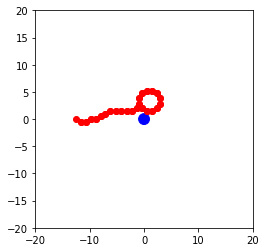

 94%|███████████████████████████████████████████████████████████████████▋    | 470000/500000 [1:31:11<06:00, 83.26it/s]

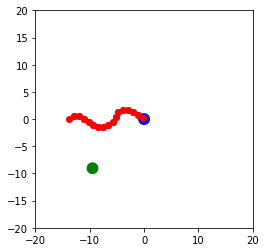

 94%|███████████████████████████████████████████████████████████████████▊    | 470990/500000 [1:31:22<05:12, 92.94it/s]

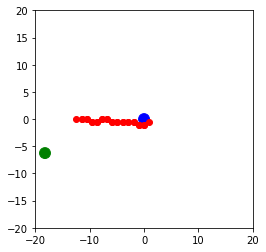

 94%|███████████████████████████████████████████████████████████████████▉    | 471995/500000 [1:31:33<05:16, 88.41it/s]

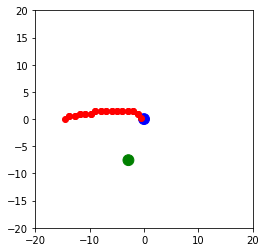

 95%|████████████████████████████████████████████████████████████████████    | 472994/500000 [1:31:44<05:09, 87.27it/s]

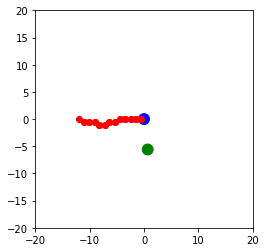

 95%|████████████████████████████████████████████████████████████████████▎   | 473993/500000 [1:31:56<04:30, 96.32it/s]

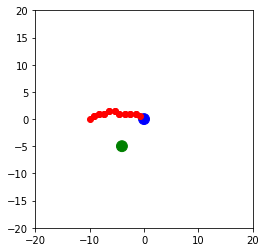

 95%|████████████████████████████████████████████████████████████████████▍   | 474998/500000 [1:32:07<04:41, 88.75it/s]

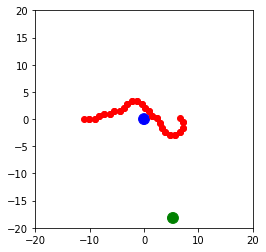

 95%|████████████████████████████████████████████████████████████████████▌   | 475995/500000 [1:32:19<04:33, 87.79it/s]

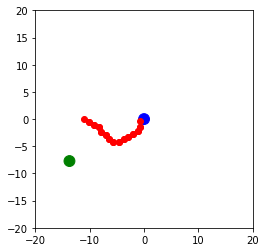

 95%|████████████████████████████████████████████████████████████████████▋   | 476998/500000 [1:32:30<04:39, 82.24it/s]

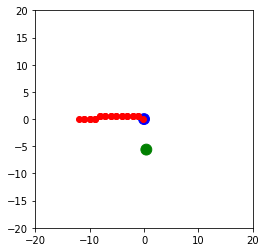

 96%|████████████████████████████████████████████████████████████████████▊   | 478000/500000 [1:32:41<04:14, 86.60it/s]

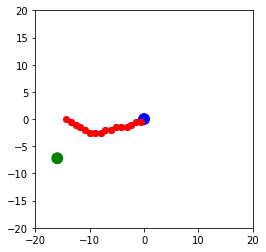

 96%|████████████████████████████████████████████████████████████████████▉   | 478995/500000 [1:32:53<03:53, 89.97it/s]

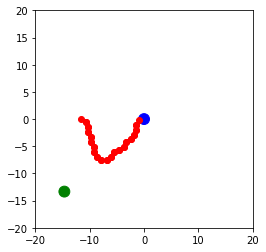

 96%|█████████████████████████████████████████████████████████████████████   | 479999/500000 [1:33:04<03:39, 91.11it/s]

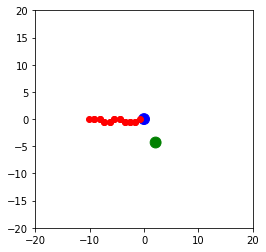

 96%|█████████████████████████████████████████████████████████████████████▎  | 480993/500000 [1:33:15<03:24, 93.10it/s]

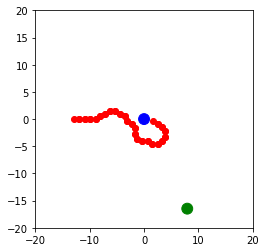

 96%|█████████████████████████████████████████████████████████████████████▍  | 481995/500000 [1:33:27<03:23, 88.28it/s]

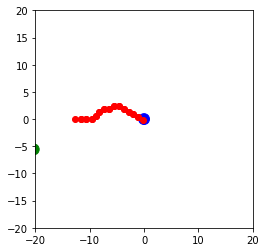

 97%|█████████████████████████████████████████████████████████████████████▌  | 482992/500000 [1:33:38<03:13, 87.77it/s]

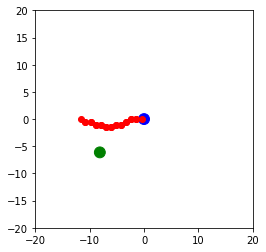

 97%|█████████████████████████████████████████████████████████████████████▋  | 483996/500000 [1:33:49<03:06, 85.86it/s]

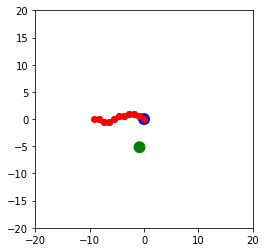

 97%|█████████████████████████████████████████████████████████████████████▊  | 484996/500000 [1:34:01<02:57, 84.73it/s]

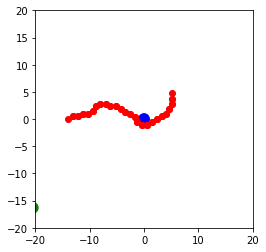

 97%|█████████████████████████████████████████████████████████████████████▉  | 485994/500000 [1:34:12<02:33, 90.98it/s]

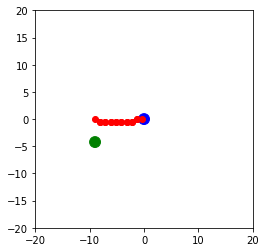

 97%|██████████████████████████████████████████████████████████████████████▏ | 486996/500000 [1:34:23<02:22, 91.05it/s]

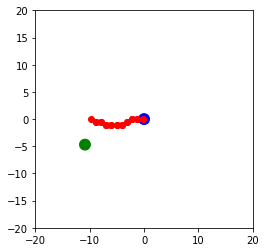

 98%|██████████████████████████████████████████████████████████████████████▎ | 488000/500000 [1:34:34<02:14, 89.18it/s]

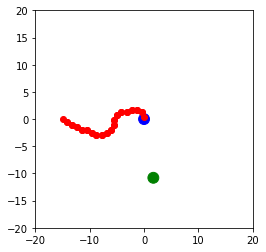

 98%|██████████████████████████████████████████████████████████████████████▍ | 488998/500000 [1:34:45<02:01, 90.33it/s]

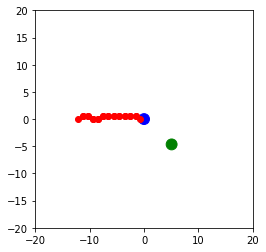

 98%|██████████████████████████████████████████████████████████████████████▌ | 489997/500000 [1:34:57<01:50, 90.64it/s]

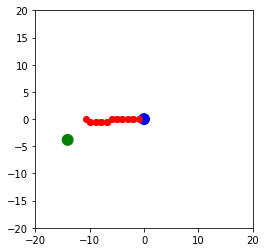

 98%|██████████████████████████████████████████████████████████████████████▋ | 490993/500000 [1:35:08<01:40, 89.33it/s]

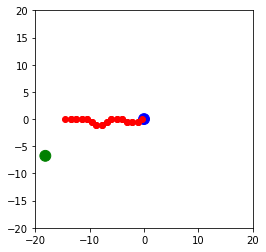

 98%|██████████████████████████████████████████████████████████████████████▊ | 491992/500000 [1:35:19<01:27, 91.33it/s]

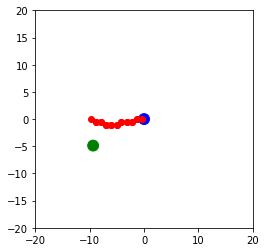

 99%|██████████████████████████████████████████████████████████████████████▉ | 492990/500000 [1:35:30<01:19, 87.65it/s]

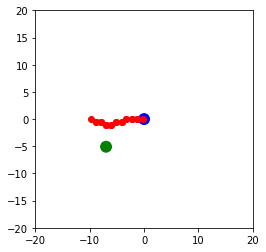

 99%|███████████████████████████████████████████████████████████████████████▏| 494000/500000 [1:35:42<01:12, 82.64it/s]

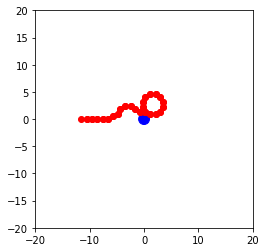

 99%|███████████████████████████████████████████████████████████████████████▎| 494991/500000 [1:35:54<00:54, 92.35it/s]

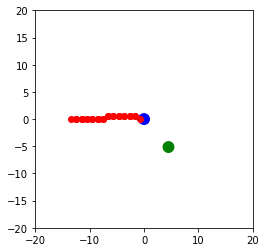

 99%|███████████████████████████████████████████████████████████████████████▍| 495998/500000 [1:36:05<00:42, 94.58it/s]

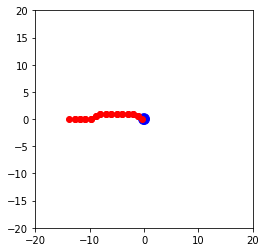

 99%|███████████████████████████████████████████████████████████████████████▌| 496999/500000 [1:36:17<00:32, 91.13it/s]

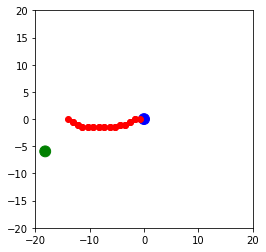

100%|███████████████████████████████████████████████████████████████████████▋| 497994/500000 [1:36:28<00:23, 86.17it/s]

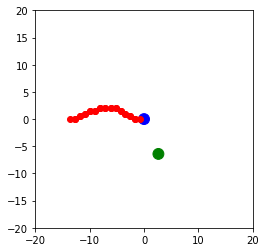

100%|███████████████████████████████████████████████████████████████████████▊| 498998/500000 [1:36:40<00:11, 90.51it/s]

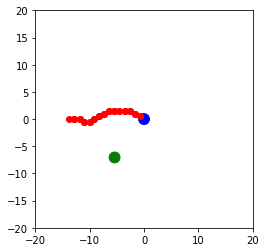

100%|████████████████████████████████████████████████████████████████████████| 500000/500000 [1:36:51<00:00, 86.03it/s]


In [113]:
rewards = []
net = DQN()

def main():
    print("The DQN is collecting experience...")
    step_counter_list = []
    for episode in tqdm.tqdm(range(EPISODES)):
        state = env.reset()
        step_counter = 0
        sum_rew = 0
        while True:
            step_counter +=1
            action = net.choose_action(state)
            next_state, reward, done = env.step(action)
            # reward = reward * 100 if reward > 0 else reward * 5
            sum_rew += reward
            net.store_trans(state, action, reward, next_state)
            if net.memory_counter >= MEMORY_CAPACITY:
                net.learn()
            if done:
                step_counter_list.append(step_counter)
                # print("episode {}, the reward is {}".format(episode, round(reward, 3)))
                rewards.append(sum_rew)
                if episode % 1000 == 0:
                    env.draw_map()
                # net.plot(net.ax, step_counter_list)
                break

            state = next_state
            

if __name__ == '__main__':
    main()

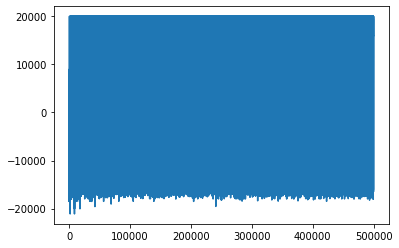

In [114]:
plt.plot(rewards)

In [115]:
m = 0
p = 0
for i in rewards:
    if i < 0:
        m += 1
    else:
        p += 1

In [116]:
m / (m + p)

0.11666

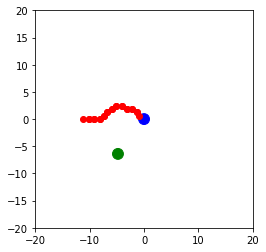

In [117]:
env.draw_map()

In [118]:
print("Running tests")
rewards = []

step_counter_list = []
for episode in tqdm.tqdm(range(EPISODES)):
    state = env.reset()
    step_counter = 0
    sum_rew = 0
    while True:
        step_counter +=1
        action = net.choose_action(state)
        next_state, reward, done = env.step(action)
        sum_rew += reward
        if done:
            rewards.append(sum_rew)
            break

        state = next_state

Running tests


100%|█████████████████████████████████████████████████████████████████████████| 500000/500000 [08:25<00:00, 988.32it/s]


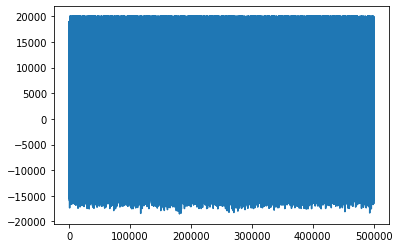

In [119]:
plt.plot(rewards)

In [120]:
m = 0
p = 0
for i in rewards:
    if i < 0:
        m += 1
    else:
        p += 1

In [121]:
m / (m + p)

0.08545

In [ ]:
class QLearningTable:
    def __init__(self, actions, learning_rate=0.01, reward_decay=0.9, e_greedy=0.9):
        self.actions = actions
        print(self.actions)
        self.lr = learning_rate
        self.gamma = reward_decay
        self.epsilon = e_greedy
        self.q_table = pd.DataFrame(columns=self.actions, dtype=np.float64)
        self.q_table_final = pd.DataFrame(columns=self.actions, dtype=np.float64)

    def choose_action(self, observation):
        self.check_state_exist(observation)
        
        if np.random.uniform() < self.epsilon:
            state_action = self.q_table.loc[observation, :]
            state_action = state_action.reindex(np.random.permutation(state_action.index))
            action = state_action.idxmax()
        else:
            action = np.random.choice(self.actions)
        return action

    def learn(self, state, action, reward, next_state):
        self.check_state_exist(next_state)

        q_predict = self.q_table.loc[state, action]

        if next_state != 'goal' or next_state != 'obstacle':
            q_target = reward + self.gamma * self.q_table.loc[next_state, :].max()
        else:
            q_target = reward
        self.q_table.loc[state, action] += self.lr * (q_target - q_predict)

        return self.q_table.loc[state, action]

    def check_state_exist(self, state):
        if state not in self.q_table.index:
            self.q_table = self.q_table.append(
                pd.Series(
                    [0]*len(self.actions),
                    index=self.q_table.columns,
                    name=state,
                )
            )